# Imports

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# Astonishingly there seems to be no clean way to set up the Python path automatically for a script that does not
# reside in the root folder. This will need to be added to all notebooks unless a better solution comes along.
import os, sys
project_root = os.path.abspath('..')
if project_root not in sys.path:
    sys.path.insert(0, project_root)

from collections import namedtuple
from pathlib import Path

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
import seaborn as sns
import scipy

from utils import load_yaml

sns.set_theme()

# Utility Functions

## Data Loading Functions

In [3]:
from tqdm import tqdm


def load_dataframes(eval_folder, verbose=False):
    """
    Given a folder with a number of pickled dataframes, load and return all of them.
    """
    if verbose:
        print(f"Loading from: {eval_folder.name}")
    all_frames = [pd.read_pickle(f) for f in eval_folder.glob("*.pkl")]
    if verbose:
        print(f"Loaded {len(all_frames)} dataframes for {eval_folder.name}.")
    return all_frames


def load_eval_data(eval_folder, verbose=False):
    """
    Given a folder with a number of pickled dataframes, load all results into a single dataframe.
    """
    all_frames = load_dataframes(eval_folder)  # Don't need the verbose flag here b/c the same info is printed below.
    if all_frames:
        all_data = pd.concat(all_frames)
    else:
        all_data = pd.DataFrame()
    if verbose:
        name = eval_folder.parent.name + "/" + eval_folder.name
        print(f"{name}: Loaded {len(all_frames)} dataframes for total size = {all_data.shape}")
    return all_data


def get_dataset_name(cfg):
    """
    Get the corrected name of the dataset specified in the given config.
    """
    if cfg["dataset"] == "omniimage":
        # Update OmniImage dataset name to disambiguate between different parameterizations.
        return "omniimage" + str(cfg["imgs_per_class"])
    return cfg["dataset"]


PreTrainData = namedtuple("PreTrainData", ["src_name", "target_name", "dflt"])
PRETRAIN_METADATA = [
    PreTrainData("model_name", "model_name", "n/a"),
    PreTrainData("train_method", "train_method", "n/a"),
    PreTrainData("lobotomize", "lobotomize", False),
    PreTrainData("lr", "train_lr", 0.0),  # Avoid name collision with transfer learning rate.
    PreTrainData("inner_lr", "inner_lr", 0.0),
    PreTrainData("outer_lr", "outer_lr", 0.0),
    PreTrainData("seed", "seed", 0),
]


def load_eval_data_with_model_info(model_name, eval_folder, train_configs, add_pretrain_info=True, verbose=False):
    """
    Load dataframes in the given folder, and edit the associated metadata.
    """
    all_data = load_eval_data(eval_folder, verbose)
    
    # Rename some columns and add some extra metadata.
    if len(all_data) > 0:
        # Get the eval and train configs. NOTE: Assumes one config per folder.
        eval_cfg = load_yaml(next(iter(eval_folder.glob("eval-config-*.yml"))))
        train_cfg = train_configs[eval_folder.parent.stem]

        # Replace model path with model shortname.
        # TODO: Need to find a more efficient way to do this.
        # Here's the original way to do it, and it's way too slow.
        #orig = all_data.index.get_level_values("model")[0]  # Get original name.
        #all_data.rename(index={orig: model_name}, level="model", inplace=True)  # Replace with short name.
        newdex = all_data.index.to_frame(index=False)
        newdex["model"] = model_name  # Replace entire model column w/ short name.
        
        # Set dataset names for train and test.
        # TODO: This should be done in the eval script itself.
        newdex.drop("dataset", axis=1, inplace=True)
        newdex.insert(1, "eval_dataset", get_dataset_name(eval_cfg))
        newdex.insert(1, "train_dataset", get_dataset_name(train_cfg))

        # Add info from a few select columns so we can use it for filtering/grouping.
        if add_pretrain_info:
            # We would allow them to be null if missing, except NaNs will mess up our groupbys due to a known bug
            # in Pandas: https://github.com/pandas-dev/pandas/issues/36470
            # Thus, we must supply non-null defaults.
            for k, target, dflt in PRETRAIN_METADATA:
                # Unfortunately our default for lobo is context-dependent. :-(
                if k == "lobotomize":
                    dflt = (train_cfg.get("train_method") != "iid")
                newdex[target] = train_cfg.get(k, dflt)

        newdex = pd.MultiIndex.from_frame(newdex, names=newdex.columns)
        all_data.set_index(newdex, inplace=True)

    return all_data


## Summarization Functions

Functions for processing dataframes to find the best performance within certain groupings.

In [4]:
from functools import partial


def combine_train_test_columns(df):
    # Combine train/test columns into a single column, for the convenience of using `sns.relplot()`.
    df = df.rename(columns={"train_acc": "train", "test_acc": "test"})
    df = df.melt(var_name="split", value_name="accuracy", ignore_index=False)
    df.set_index("split", append=True, inplace=True)
    return df


def get_index_columns(df, include=None, exclude=None):
    if not include:
        include = df.index.names
    if not exclude:
        exclude = []
    return list(filter(lambda x: x in include and x not in exclude, df.index.names))


def get_all_model_descriptor_columns(df, exclude=None):
    """
    Get a list of columns from the given dataframe which describe how a model was pre-trained.
    """
    model_cols = ["train_dataset"] + [md.target_name for md in PRETRAIN_METADATA]
    return get_index_columns(df, include=model_cols, exclude=exclude)


def get_unique_model_descriptor_columns(df):
    """
    Get a list of columns from the given dataframe which can be used to uniquely identify a model type, if we ignore
    random seed ("seed") and W&B run name ("model").
    """
    return get_all_model_descriptor_columns(df, exclude=["seed"])


def get_model_descriptions(df):
    """
    Get a dataframe with one row per unique model, and columns to describe the settings used to train that model.
    """
    model_cols = get_all_model_descriptor_columns(df)
    return df.groupby("model").apply(lambda group: group.index.to_frame().iloc[0][model_cols])


def ensure_unique(df, index_columns):
    """
    Ensures that the given columns only contain one value; otherwise raises an exception.

    This is a safety check to ensure we don't erroneously aggregate across runs that aren't comparable. For example,
    if our dataframe could have results from more than one model, we don't usually want to aggregate over all models,
    so we would pass in the "model" column here.
    """
    if isinstance(index_columns, str):
        index_columns = [index_columns]
    for col in index_columns:
        unique = df.index.get_level_values(col).unique()
        if len(unique) > 1:
            raise RuntimeError(f"Refusing to aggregate across runs with different '{col}': {unique.to_numpy()}.")


def drop_top5_columns(df):
    """
    Remove any "Top-5 Accuracy" columns from the dataframe, if present. (Most of the time we only want Top-1.)
    """
    top5_cols = [c for c in df.columns if "top5" in c]
    if top5_cols:
        return df.drop(top5_cols, axis="columns")
    else:
        return df.copy()


def filter_by_choices(df, index_col, desired_values):
    """
    Filter the given dataframe to only contain the rows where `index_col` takes one of the `desired_values`.
    """
    values = df.index.get_level_values(index_col)
    selected_rows = (values == desired_values[0])
    for v in desired_values[1:]:
        selected_rows |= (values == v)
    return df.loc[selected_rows]


def filter_by_value(df, index_col, desired_value):
    """
    Filter the given dataframe to only contain the rows where `index_col` takes the `desired_value`.
    """
    return filter_by_choices(df, index_col, [desired_value])



def maybe_filter_by_value(df, index_col, desired_value):
    """
    Same as `filter_by_value`, but do nothing if `desired_value` is `None`.
    """
    if desired_value is not None:
        return filter_by_choices(df, index_col, [desired_value])
    else:
        return df


def filter_by_model(df, desired_models):
    """
    Filter the given dataframe to only contain the models from the given list.
    """
    return filter_by_choices(df, "model", desired_models)


def filter_to_match_models(df1, df2):
    """
    Filter `df1` to only contain the models found in `df2`.
    """
    return filter_by_model(df1, df2.index.get_level_values("model").unique())


def rename_like_models(df):
    """
    Sets the "model" column so that all models which share the same training settings, but differ only in random seed,
    will then share the same name. Each group will take the alphabetically first name.

    Args:
        df: The dataframe containing pre-trained model info.

    Returns:
        The same dataframe but with modified "model" values.
    """
    model_cols = get_unique_model_descriptor_columns(df)
    
    # We group by just the model descriptors. We keep each group the same, but we reassign the model name to be all
    # the same.
    def rename_group(group):
        # Choose a single name to represent the whole group.
        new_model_name = group.index.get_level_values("model").min()
        # Drop the existing "model" column from the index, and rebuild the index using a new model name.
        index_cols = get_index_columns(group, exclude=model_cols)
        newgroup = group.reset_index()
        # Drop all columns which will already be in the output.
        newgroup.drop(model_cols, axis=1, inplace=True)
        newgroup["model"] = new_model_name
        newgroup.set_index(index_cols, inplace=True)
        return newgroup
        
    df = df.groupby(model_cols, dropna=False).apply(rename_group)
    # Reset index to put model in the front.
    index_cols = get_index_columns(df, exclude=["model"])
    df.reset_index(inplace=True)
    df.set_index(["model"] + index_cols, inplace=True)
    
    # An alternative method is below. This is more concise, but unfortunately isn't sufficient, b/c some models are
    # missing from some categories. You need to take the min model name over *all*, not just per subgroup.
    # df = df.reset_index(level="model")
    # df = df.groupby(model_cols, dropna=False).agg({"model": "min", "accuracy": "mean"})
    # # Need to reset the whole index to get "model" back into the first slot.
    # df.reset_index(inplace=True)
    # df.set_index(["model"] + index_cols, inplace=True)

    return df


def select_best_lr(groupby_labels, train_group):
    """
    Reduces a dataframe with many learning rates to one with one learning rate, retaining all trials for the selected
    learning rate. Learning rate is selected by highest mean test accuracy.
    """
    test_perf = train_group.loc[train_group.index.get_level_values("split") == "test"]
    perf_per_lr = test_perf.groupby("lr").mean()
    # Tells us which LR is the best.
    best_lr = perf_per_lr.iloc[perf_per_lr.squeeze().argmax()].name
    # Grabs all trials corresponding to the best LR.
    best_lr_rows = train_group.index.get_level_values("lr") == best_lr
    # We must remove all the columns that are already specified by the group, because otherwise .apply() is not smart
    # enough to remove them and they will be duplicated.
    return train_group.loc[best_lr_rows].reset_index(level=groupby_labels, drop=True)


def select_best_lr_per_group(df):
    """
    Filters the given dataframe so it contains just the results of the best-performing learning rate at each point in
    time, for each different model / fine-tuning process. Note: this means different learning rates can be selected for
    different points _within the same training run_. Performance is measured as the average test accuracy over all
    trials (mean over the "trial" column).
    """
    # Shortcut: If LR is not applicable here, just return the original data.
    if "lr" not in df.index.names:
        return df.copy()
    
    # Group the potential data for each data point separately. So each group contains all trials and all learning rates
    # for a single test method (so all index columns except for those).
    groupby_labels = get_index_columns(df, exclude=["lr", "trial", "split"])
    eval_groups = df.groupby(groupby_labels, dropna=False)

    # For each point on the x-axis, select the learning rate with the best average performance over trials.
    # Need to use .apply() here because our function needs all columns at once.
    return eval_groups.apply(partial(select_best_lr, groupby_labels))


def get_final_perf_per_model(df, num_train_examples=None, split="test", print_result=False):
    """
    Gets and (optionally) prints the mean final test accuracy of each model in the given dataframe.
    """
    models = df.index.get_level_values("model")
    test_rows = (df.index.get_level_values("split") == split)
    if num_train_examples is not None:
        train_example_rows = df.index.get_level_values("train_examples") == num_train_examples
    else:
        train_example_rows = None
    # Different evaluation methods have slightly different naming schemes, unfortunately. Support all of them.
    if "classes_trained" in df.index.names:
        classes_trained = df.index.get_level_values("classes_trained")
        final_perf_rows = (classes_trained == classes_trained.max())
    elif "step" in df.index.names:
        step = df.index.get_level_values("step")
        final_perf_rows = (step == step.max())
    else:
        final_perf_rows = None

    if print_result:
        total_classes = df.index.get_level_values("classes").unique()
        if len(total_classes) > 1:
            print(f"WARNING: Aggregating over multiple class values:\n{total_classes}")
            cls_msg = ""
        else:
            cls_msg = f" on {total_classes.item()} classes"
        print(f"Final accuracy{cls_msg}:")

    final_perf_per_model = {}
    for m in sorted(models.unique()):
        rows = (models == m) & test_rows
        if train_example_rows is not None:
            rows &= train_example_rows
        if final_perf_rows is not None:
            rows &= final_perf_rows
        final_acc = df.loc[rows, "accuracy"]
        stats = pd.DataFrame.from_records([{"model": m, "mean": final_acc.mean(), "std": final_acc.std()}],
                                          index="model")
        final_perf_per_model[m] = stats
        if print_result:
            print(f"{m: >30} | {stats['mean'].item():>5.1%} (std: {stats['std'].item():.1%})")

    return final_perf_per_model


def get_top_model_per_group(df, performance_per_model, group_cols=None):
    """
    Groups by the given columns and returns one model per group, where each model is the one with the highest average
    performance within that group, according to `performance_per_model`.

    Args:
        df: The dataframe containing pre-trained model info.
        performance_per_model: A dict with model names as keys and performance stats as values (higher is better).
        group_cols: A list of columns used to define the groups. Defaults to ["train_method", "lobotomize"] if not
                    supplied.

    Returns:
        A dataframe with one row per group, indexed by group columns and with a single column with the model names.
    """
    if not group_cols:
        group_cols = ["train_method", "lobotomize"]

    def select_best_model(train_group):
        models = train_group.index.get_level_values("model").unique()
        # Sort by mean and return the highest (last) one.
        return sorted([performance_per_model[m] for m in models], key=lambda e: e["mean"].item())[-1]

    # Now select the best model within each group.
    pretrain_groups = df.groupby(group_cols, dropna=False)
    return pretrain_groups.apply(select_best_model)


## Plotting Functions

In [5]:
import warnings


def add_category_column(df, group_cols=None):
    """
    Add a column to the given dataframe which summarizes the category groups in a string. Used to make an improved
    legend in plots. If `groupcols` is not provided, it defaults to ["train_method", "lobotomize"].
    """
    if not group_cols:
        group_cols = ["train_method", "lobotomize"]
    group_pos = [df.index.names.index(c) for c in group_cols]
    name_mapping = {
        "lobotomize": "lobo",
        "train_method": "method",
        "sequential_episodic": "seqep",
    }

    def map_name(name):
        return name_mapping.get(name, name)

    def make_valstring(row):
        msg = f"{map_name(group_cols[0])}={map_name(row.name[group_pos[0]])}"
        for i in range(1, len(group_cols)):
            msg += f", {map_name(group_cols[i])}={map_name(row.name[group_pos[i]])}"
        return msg

    df["category"] = df.apply(make_valstring, axis=1)


def set_pivot_if_applicable(d, df, pivot_type, colname):
    """
    If the given `pivot_type` is not already present in dictionary `d`, this sets `colname` as that pivot, if such
    a column exists.
    """
    if pivot_type not in d and df.index.get_level_values(colname).nunique() > 1:
        d[pivot_type] = colname


# Plot the results from the previous cell.
def plot_traj_per_lr(df, **kwargs):
    # We want to make sure we are not accidentally aggregating across runs with different configs.
    ensure_unique(df, ["eval_dataset", "test_examples", "classes", "eval_method", "opt_params", "reinit_method"])
    # Only add more levels of nesting if needed.
    set_pivot_if_applicable(kwargs, df, "hue", "model")
    set_pivot_if_applicable(kwargs, df, "hue", "lr")
    set_pivot_if_applicable(kwargs, df, "style", "train_examples")
    # Different evaluation methods have slightly different naming schemes, unfortunately. Support all of them.
    xname = "Step"
    if "x" not in kwargs:
        if "classes_trained" in df.index.names:
            kwargs["x"] = "classes_trained"
            xname = "Classes Trained"
        elif "step" in df.index.names:
            kwargs["x"] = "step"
        else:
            raise RuntimeError("Unable to find a suitable x-axis variable in the dataframe.")

    # Temporarily suppress this annoying and unnecessary warning coming from Seaborn.
    with warnings.catch_warnings():
        warnings.filterwarnings("ignore", message=".*not compatible with tight_layout.*")
        fg = sns.relplot(
            data=df,
            y="accuracy",
            row="split",
            kind="line",
            ci="sd",
            height=5,
            aspect=2.5,
            facet_kws=dict(sharey=False, gridspec_kws=dict(top=0.90)),
            **kwargs
        )
    # Adjust labels.
    fg.set_axis_labels(xname, "Accuracy")

# Data Loading

## Scan for Trained Models

Given a project folder, we will scan for all the training jobs in that folder. Each training job has produced a number of model checkpoints, and we will find all the ones which have already been evaluated.

This assumes that project folders have the structure: `<project>/<training-job>/train-config.yml`.

In [6]:
# Original Omniglot results.
#PROJECT_ROOT = Path("../experiments/flat-vs-nested")
# Original ImageNet results.
#PROJECT_ROOT = Path("../experiments/inet-flat-vs-nested").resolve()
# New results.
PROJECT_ROOT = Path("../experiments/monster").resolve()

In [7]:
# Create a map from name -> training config.
train_config_files = {}
for f in PROJECT_ROOT.iterdir():
    if f.is_dir():
        cfg_path = f / "train-config.yml"
        if cfg_path.is_file():
            train_config_files[f.stem] = cfg_path

# Let's sort the dict by model name, for convenience.
train_config_files = dict(sorted(train_config_files.items()))

In [8]:
# Load the YAML files.
train_configs = {k: load_yaml(v) for k, v in train_config_files.items()}
print(f"Found {len(train_configs)} training jobs.")

Found 338 training jobs.


## Choose the "Best" Checkpoint

Each model may have a number of evaluated checkpoints. For each training job, we'll choose just one checkpoint to use for evaluation. We'll do so by choosing the checkpoint with the best "zero-shot" or "no-SGD" performance.

Note that there are a bunch of assumptions in the code below about what results we actually have:
1. All models have no-SGD results, otherwise they're ignored.
1. Each checkpoint only has one no-SGD evaluation.
1. Each no-SGD folder only contains one set of trials.
1. Some assumptions on the naming of these folders.
If we ever decide to run more different no-SGD evals then these assumptions need to be revisited.

In [9]:
def best_checkpoint(eval_folders):
    if len(eval_folders) == 1:
        return eval_folders[0]
    perfs = np.array([final_performance(f) for f in eval_folders])
    if np.all(np.isnan(perfs)):
        return None
    return eval_folders[np.nanargmax(perfs)]


def final_performance(eval_folder):
    df = load_eval_data(eval_folder)
    if df.empty:
        return np.nan
    # WARNING: Assumes all datapoints in this folder correspond to a single evaluation (we don't need to filter down
    # to the evaluation we actually want).
    return df["test_acc"].mean()


def get_checkpoint_number(eval_folder):
    # WARNING: This CLOSELY depends on the naming of the eval folders, and I'm not sure it'll always work.
    return int(eval_folder.stem.split("-")[2])


best_checkpoints = {}
for name, f in train_config_files.items():
    pdir = f.parent
    # First check for folders just ending with "no-sgd".
    no_sgd_evals = list(pdir.glob("eval-*-no-sgd"))
    if not no_sgd_evals:
        # If we don't find "no-sgd", there might be multiple and we should find the "large" one.
        no_sgd_evals = list(pdir.glob("eval-*-no-sgd-*-lg"))
        if not no_sgd_evals:
            print(f"WARNING: Could not find no-SGD results for {name}.")
            continue
            # If you want to debug this condition, uncomment the following line:
            # print(f"Files: {[f.name for f in pdir.iterdir()]}")

    # Now we have a list of evals; assuming one per checkpoint.
    best = best_checkpoint(no_sgd_evals)
    if best is not None:
        best_checkpoints[name] = get_checkpoint_number(best)
    else:
        print(f"WARNING: All no-SGD results for {name} are empty.")

print(f"\nFound a total of {len(best_checkpoints)} models to compare.")


Found a total of 225 models to compare.


In [23]:
# Create a map of name -> list of eval folders for the best checkpoint.
# WARNING: Closely depends on the naming of the eval folders, and may not stand the test of time.
all_eval_folders = {name: list((PROJECT_ROOT / name).glob(f"eval-*-{ckpt}-*"))
                    for name, ckpt in best_checkpoints.items()}
# Sanity check.
missing_results = []
invalid_results = []
for name, l in all_eval_folders.items():
    if len(l) <= 1:
        # The only result is the no-sgd result, or even that was not found for some reason.
        missing_results.append(name)
    for f in l:
        if not f.is_dir():
            # Not a valid results dir.
            invalid_results.append(f)

if missing_results:
    for name in missing_results:
        print(f"WARNING: Unable to find any results for {name}, checkpoint #{best_checkpoints[name]}.")
if invalid_results:
    print(f"ERROR: The following should be valid directories but are not:\n{[f.name for f in invalid_results]}")

## Load Evaluation Data

Now, for each model, we have all the evals performed on the best model checkpoint. We'd like to load all these evals into a single dataframe for further processing.

For brevity, we want each model to have a "short name" that can be used in plots and legends. This will replace the original `model` column, which is a filename. We'll name them using the training job name and the model checkpoint.

In [24]:
import re

def flavor_from_folder(folder):
    return re.match(r".*?-[0-9]+-(.*)$", folder.name).group(1)

In [25]:
%%time

from collections import defaultdict


# Organize dataframes by evaluation type.
all_frames = defaultdict(list)
for name, eval_folders in tqdm(all_eval_folders.items()):
    #print(f"Loading {len(eval_folders)} evaluations for {name}...")
    for folder in eval_folders:
        eval_type = flavor_from_folder(folder)
        eval_data = load_eval_data_with_model_info(f"{name}-{best_checkpoints[name]}", folder, train_configs)
        all_frames[eval_type].append(eval_data)

print("Evaluation Results:")
for eval_type in all_frames:
    before_concat = all_frames[eval_type]
    all_frames[eval_type] = pd.concat(before_concat)
    print(f"  {eval_type}: {len(before_concat)} models -> {all_frames[eval_type].shape} dataframe")

100%|██████████| 225/225 [07:39<00:00,  2.04s/it]


Evaluation Results:
  iid-unfrozen: 225 models -> (161000, 4) dataframe
  no-sgd: 225 models -> (2210, 4) dataframe
  unfrozen: 225 models -> (141159000, 2) dataframe
  iid-unfrozen-5epochs: 171 models -> (354930, 4) dataframe
  iid-unfrozen-lg: 54 models -> (261210, 4) dataframe
  no-sgd-lg: 54 models -> (510, 4) dataframe
  olft: 99 models -> (88448000, 2) dataframe
  iid-unfrozen-med: 36 models -> (68800, 4) dataframe
  iid-olft: 45 models -> (48150, 4) dataframe
  iid-unfrozen-full: 2 models -> (17520, 4) dataframe
CPU times: user 9min 1s, sys: 46 s, total: 9min 47s
Wall time: 10min 52s


In [26]:
# Clear up what memory we can, in case we are loading some large frames...
# In my experiment with 144M rows, this took memory from 7.2 GB --> 6.2 GB; not that much, unfortunately.
import gc
del before_concat
del eval_data
_ = gc.collect()

## Dataframe View

In [36]:
filter_by_value(all_frames["iid-unfrozen-5epochs"], "train_dataset", "omniimage20")

train_acc  \
model                     train_dataset eval_dataset train_examples test_examples eval_method reinit_method reinit_params     opt_params classes epochs batch_size lr     trial epoch step model_name train_method lobotomize train_lr inner_lr outer_lr seed               
absurd-monkey-12273-25000 omniimage20   omniimage20  15             5             iid         kaiming       classifier.linear all        300     5      128        0.0004 0     0     1    sanml      meta         True       0.0      0.001    0.001    29384   0.002222   
                                                                                                                                                                                      5    sanml      meta         True       0.0      0.001    0.001    29384   0.048000   
                                                                                                                                                                                      10   sanml      meta         True       0.0      0.001    0.001    29384   0.135778   
                                                                                                                                                                                      15   sanml      meta         True       0.0      0.001    0.001    29384   0.248000   
                                                                                                                                                                                      20   sanml      meta         True       0.0      0.001    0.001    29384   0.362222   
...                                                                                                                                                                                                                                                                   ...   
woven-water-12303-25000   omniimage20   omniimage20  15             5             iid         kaiming       classifier.linear all        300     5      128        0.0007 9     4     160  sanml      meta         True       0.0      0.001    0.010    29384   0.999556   
                                                                                                                                                                                      165  sanml      meta         True       0.0      0.001    0.010    29384   0.999556   
                                                                                                                                                                                      170  sanml      meta         True       0.0      0.001    0.010    29384   0.999556   
                                                                                                                                                                                      175  sanml      meta         True       0.0      0.001    0.010    29384   0.999556   
                                                                                                                                                                                      180  sanml      meta         True       0.0      0.001    0.010    29384   0.999556   

                                                                                                                                                                                                                                                                train_top5_acc  \
model                     train_dataset eval_dataset train_examples test_examples eval_method reinit_method reinit_params     opt_params classes epochs batch_size lr     trial epoch step model_name train_method lobotomize train_lr inner_lr outer_lr seed                    
absurd-monkey-12273-25000 omniimage20   omniimage20  15             5             iid         kaiming       classifier.linear all        300     5      128        0.0004 0     0     1    sanml      meta        

# Determine the "Best" Versions of Each Pre-Train Type

For each of the different pre-train settings we're interested in, we've trained that setting with a number of different hyperparameters. Within each setting, we want to select the best single set of hyperparams. We'll do this by using the No-SGD performance as a proxy for overall "goodness".

In [64]:
# Using No-SGD performance as a proxy for overall performance.
perf_proxy = all_frames["no-sgd"]

# Make sure we are using the full downstream dataset to estimate performance.
# TODO: Change this to 500. For now, we only have data for 30 examples per class. :-(
rows = perf_proxy.index.get_level_values("train_examples") == 30
desired_rows = perf_proxy.loc[rows]

# Group the potential data for each data point separately. So each group contains all trials and all learning rates for
# a single test method (so all index columns except for those).
perf_proxy_pretrain_groups = desired_rows.groupby(["train_method", "lobotomize"], dropna=False)

def select_best_model(train_group):
    """
    Returns the best model among this group, according to mean test accuracy.
    """
    model_perf = train_group.groupby("model").mean()
    # Tells us which LR is the best.
    return model_perf.iloc[model_perf.loc[:, "test_acc"].argmax()].name

# For each point on the x-axis, select the learning rate with the best average performance over trials.
# Need to use .apply() here because our function needs all columns at once.
best_model_per_setting = perf_proxy_pretrain_groups.apply(select_best_model)
best_model_per_setting

train_method         lobotomize
iid                  False                 bright-peony-266-3750
meta                 False         blooming-resonance-3585-25000
                     True               fragrant-tree-3494-25000
sequential_episodic  False           blooming-universe-3825-9000
                     True                   smart-haze-3780-9000
dtype: object

# Sequential Fine-Tuning Evaluation

In the sequential evaluation method, we record per-class performance separately for each class at each step of training. For most plots, we only want to evaluate on classes seen so far, so we insert NaN values in places where the class had not yet been trained on. In addition, we only want to see overall performance, not per-class performance, so we summarize this ahead of time.

These steps aren't needed for other training methods, since we don't record per-class performance in those cases.

In [39]:
def summarize_per_class_performance(classes_seen_perf, inplace=False):
    if not inplace:
        classes_seen_perf = classes_seen_perf.copy()
    
    # Shortcut for dataframes where this doesn't apply.
    if "classes_trained" not in classes_seen_perf.index.names:
        return classes_seen_perf

    # Nix all rows where classes_trained <= class_id.
    unseen_rows = (classes_seen_perf.index.get_level_values("classes_trained") <=
                   classes_seen_perf.index.get_level_values("class_id"))
    classes_seen_perf[unseen_rows] = np.nan

    # Average over all classes to get overall performance numbers, by grouping by columns other than class.
    groupby_labels = get_index_columns(classes_seen_perf, exclude=["class_id"])
    over_all_classes = classes_seen_perf.groupby(groupby_labels, dropna=False).mean()

    if not inplace:
        # Optional deletion of intermediate data to save more memory.
        del classes_seen_perf
        _ = gc.collect()

    return over_all_classes

## Sequential Unfrozen

Summarize the unfrozen sequential transfer learning, and view the dataframe to check the structure.

In [104]:
%%time

olft = all_frames["unfrozen"]
olft = filter_by_value(olft, "train_dataset", "omniimage20")
olft_over_all_classes = summarize_per_class_performance(olft)
olft_over_all_classes

CPU times: user 34.1 s, sys: 3.13 s, total: 37.2 s
Wall time: 37.7 s


train_acc  \
model                      train_dataset eval_dataset train_examples test_examples eval_method reinit_method reinit_params     opt_params classes lr      trial epoch classes_trained model_name train_method lobotomize train_lr inner_lr outer_lr seed               
ancient-puddle-12220-25000 omniimage20   omniimage20  15             5             sequential  kaiming       classifier.linear all        300     0.00004 0     0     1               sanml      meta         True       0.0      0.01     0.001    93242   0.000000   
                                                                                                                                                                9     10              sanml      meta         True       0.0      0.01     0.001    93242   0.060000   
                                                                                                                                                                19    20              sanml      meta         True       0.0      0.01     0.001    93242   0.176667   
                                                                                                                                                                29    30              sanml      meta         True       0.0      0.01     0.001    93242   0.255556   
                                                                                                                                                                39    40              sanml      meta         True       0.0      0.01     0.001    93242   0.280000   
...                                                                                                                                                                                                                                                              ...   
vital-glade-12341-25000    omniimage20   omniimage20  15             5             sequential  kaiming       classifier.linear all        300     0.00550 9     259   260             sanml      meta         False      0.0      0.01     0.001    49289   0.016154   
                                                                                                                                                                269   270             sanml      meta         False      0.0      0.01     0.001    49289   0.003704   
                                                                                                                                                                279   280             sanml      meta         False      0.0      0.01     0.001    49289   0.007143   
                                                                                                                                                                289   290             sanml      meta         False      0.0      0.01     0.001    49289   0.005517   
                                                                                                                                                                299   300             sanml      meta         False      0.0      0.01     0.001    49289   0.006000   

                                                                                                                                                                                                                                                           test_acc  
model                      train_dataset eval_dataset train_examples test_examples eval_method reinit_method reinit_params     opt_params classes lr      trial epoch classes_trained model_name train_method lobotomize train_lr inner_lr outer_lr seed             
ancient-puddle-12220-25000 omniimage20   omniimage20  15             5             sequential  kaiming       classifier.linear all        300     0.00004 0     0     1               sanml      meta         True       0.0      0.01     0.001    93242  0.000000  
                                

In [105]:
get_model_descriptions(olft_over_all_classes)

,train_dataset,model_name,train_method,lobotomize,train_lr,inner_lr,outer_lr,seed
model,,,,,,,,
ancient-puddle-12220-25000,omniimage20,sanml,meta,True,0.0000,0.010,0.001,93242
auspicious-dumpling-27-1260,omniimage20,resnet18,iid,False,0.0003,0.000,0.000,93242
beaming-rabbit-47-1260,omniimage20,sanml,iid,False,0.0030,0.000,0.000,49289
breezy-bush-12646-9000,omniimage20,sanml,sequential_episodic,True,0.0000,0.001,0.010,49289
bright-monkey-26-1260,omniimage20,resnet18,iid,False,0.0003,0.000,0.000,29384
brilliant-pig-60-1260,omniimage20,sanml,iid,False,0.0010,0.000,0.000,93242
chromatic-festival-44-1260,omniimage20,sanml,iid,False,0.0030,0.000,0.000,93242
crimson-mandu-41-1260,omniimage20,sanml,iid,False,0.0030,0.000,0.000,29384
eager-microwave-12490-9000,omniimage20,sanml,sequential_episodic,True,0.0000,0.001,0.001,29384


Melt the two train/test accuracy columns into one, to make it easier to plot both simultaneously with Seaborn.

In [106]:
olft_overall_accuracy = combine_train_test_columns(olft_over_all_classes)

Rename models so we can more easily aggregate the random seeds together and get error bars over all training runs. Check the model descriptions to verify that models have been successfully divided into unique categories.

In [107]:
olft_overall_accuracy = rename_like_models(olft_overall_accuracy)

In [108]:
olft_overall_accuracy
get_model_descriptions(olft_overall_accuracy)

,train_dataset,model_name,train_method,lobotomize,train_lr,inner_lr,outer_lr,seed
model,,,,,,,,
ancient-puddle-12220-25000,omniimage20,sanml,meta,True,0.0000,0.010,0.001,93242
auspicious-dumpling-27-1260,omniimage20,resnet18,iid,False,0.0003,0.000,0.000,93242
beaming-rabbit-47-1260,omniimage20,sanml,iid,False,0.0030,0.000,0.000,49289
breezy-bush-12646-9000,omniimage20,sanml,sequential_episodic,True,0.0000,0.001,0.010,49289
brilliant-pig-60-1260,omniimage20,sanml,iid,False,0.0010,0.000,0.000,93242
eager-microwave-12490-9000,omniimage20,sanml,sequential_episodic,True,0.0000,0.001,0.001,29384
effortless-vortex-12320-25000,omniimage20,sanml,meta,True,0.0000,0.001,0.010,49289
ethereal-bird-12408-25000,omniimage20,sanml,meta,False,0.0000,0.001,0.010,29384
expert-salad-12713-9000,omniimage20,sanml,sequential_episodic,False,0.0000,0.001,0.010,29384


Now, plot a graph with the best learning rate per data point.

In [109]:
olft_overall_accuracy.index.get_level_values("train_examples").unique()

Int64Index([15], dtype='int64', name='train_examples')

In [110]:
# Filter the data to just N examples per class.
# num_train_examples = 10
# rows = olft_overall_accuracy.index.get_level_values("train_examples") == num_train_examples
# olft_one_train_size = olft_overall_accuracy.loc[rows]

# Or, don't filter.
num_train_examples = None
olft_one_train_size = olft_overall_accuracy

# Now select one LR per pretrain group.
olft_best_lrs = select_best_lr_per_group(olft_one_train_size)

/users/n/t/ntraft/miniconda3/envs/deep-amd-3.9/lib/python3.9/site-packages/seaborn/axisgrid.py:848: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar='sd'` for the same effect.

  func(*plot_args, **plot_kwargs)
/users/n/t/ntraft/miniconda3/envs/deep-amd-3.9/lib/python3.9/site-packages/seaborn/axisgrid.py:848: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar='sd'` for the same effect.

  func(*plot_args, **plot_kwargs)


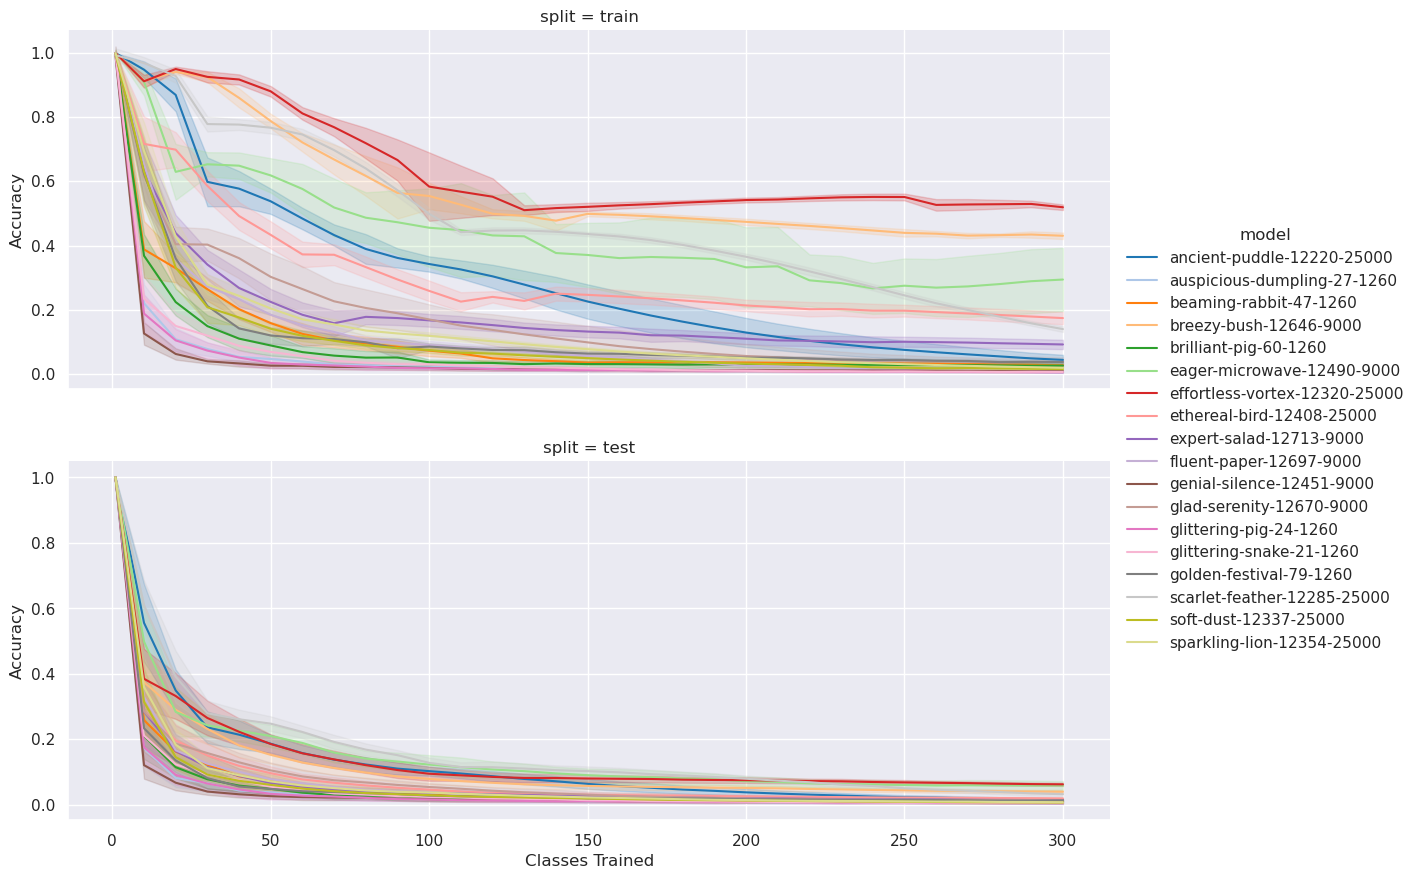

In [111]:
# Plot results
fg = plot_traj_per_lr(olft_best_lrs, palette="tab20")

Or we could also plot a graph with just one model, all learning rates.

/users/n/t/ntraft/miniconda3/envs/deep-amd-3.9/lib/python3.9/site-packages/seaborn/axisgrid.py:848: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar='sd'` for the same effect.

  func(*plot_args, **plot_kwargs)
/users/n/t/ntraft/miniconda3/envs/deep-amd-3.9/lib/python3.9/site-packages/seaborn/axisgrid.py:848: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar='sd'` for the same effect.

  func(*plot_args, **plot_kwargs)


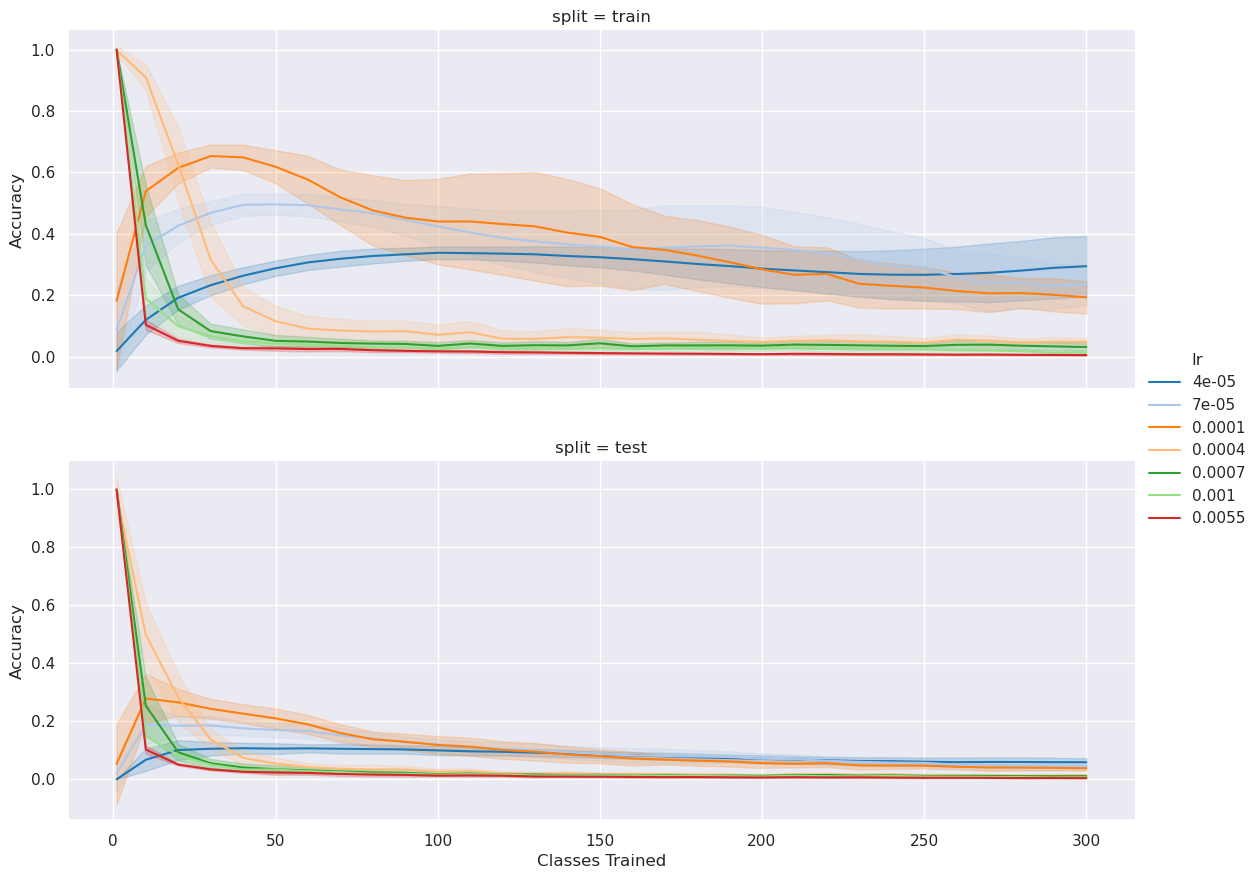

In [119]:
rows = olft_one_train_size.index.get_level_values("model") == "eager-microwave-12490-9000"
desired_rows = olft_one_train_size.loc[rows]
fg = plot_traj_per_lr(desired_rows, palette="tab20")

### Best Models Overall

Rate each model based on final test performance with its best LR. Also show training details for each model.

In [113]:
# Print final accuracy per model, when fine-tuned on this number of examples.
olft_perf_per_model = get_final_perf_per_model(olft_best_lrs, num_train_examples, print_result=True)

Final accuracy on 300 classes:
    ancient-puddle-12220-25000 |  1.6% (std: 0.4%)
   auspicious-dumpling-27-1260 |  0.5% (std: 0.2%)
        beaming-rabbit-47-1260 |  1.2% (std: 0.3%)
        breezy-bush-12646-9000 |  4.0% (std: 0.5%)
         brilliant-pig-60-1260 |  1.2% (std: 0.3%)
    eager-microwave-12490-9000 |  5.9% (std: 1.3%)
 effortless-vortex-12320-25000 |  6.3% (std: 0.5%)
     ethereal-bird-12408-25000 |  2.0% (std: 0.4%)
       expert-salad-12713-9000 |  1.4% (std: 0.3%)
       fluent-paper-12697-9000 |  0.6% (std: 0.2%)
     genial-silence-12451-9000 |  0.8% (std: 0.4%)
      glad-serenity-12670-9000 |  1.4% (std: 0.4%)
        glittering-pig-24-1260 |  0.5% (std: 0.2%)
      glittering-snake-21-1260 |  0.6% (std: 0.3%)
       golden-festival-79-1260 |  1.4% (std: 0.4%)
   scarlet-feather-12285-25000 |  3.3% (std: 0.6%)
         soft-dust-12337-25000 |  0.7% (std: 0.3%)
    sparkling-lion-12354-25000 |  0.8% (std: 0.2%)


In [114]:
get_model_descriptions(olft_best_lrs)

,train_dataset,model_name,train_method,lobotomize,train_lr,inner_lr,outer_lr,seed
model,,,,,,,,
ancient-puddle-12220-25000,omniimage20,sanml,meta,True,0.0000,0.010,0.001,29384
auspicious-dumpling-27-1260,omniimage20,resnet18,iid,False,0.0003,0.000,0.000,29384
beaming-rabbit-47-1260,omniimage20,sanml,iid,False,0.0030,0.000,0.000,29384
breezy-bush-12646-9000,omniimage20,sanml,sequential_episodic,True,0.0000,0.001,0.010,29384
brilliant-pig-60-1260,omniimage20,sanml,iid,False,0.0010,0.000,0.000,29384
eager-microwave-12490-9000,omniimage20,sanml,sequential_episodic,True,0.0000,0.001,0.001,29384
effortless-vortex-12320-25000,omniimage20,sanml,meta,True,0.0000,0.001,0.010,49289
ethereal-bird-12408-25000,omniimage20,sanml,meta,False,0.0000,0.001,0.010,29384
expert-salad-12713-9000,omniimage20,sanml,sequential_episodic,False,0.0000,0.001,0.010,29384


In [115]:
# Get the top N models according to final test performance.
num_top_models = 5
sorted_models = sorted(olft_perf_per_model, key=lambda k: olft_perf_per_model[k]["mean"].item(), reverse=True)
top_models = sorted_models[:num_top_models]
print(f"Top models: {top_models}")
top_model_df = filter_by_model(olft_best_lrs, top_models)

Top models: ['effortless-vortex-12320-25000', 'eager-microwave-12490-9000', 'breezy-bush-12646-9000', 'scarlet-feather-12285-25000', 'ethereal-bird-12408-25000']


/users/n/t/ntraft/miniconda3/envs/deep-amd-3.9/lib/python3.9/site-packages/seaborn/axisgrid.py:848: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar='sd'` for the same effect.

  func(*plot_args, **plot_kwargs)
/users/n/t/ntraft/miniconda3/envs/deep-amd-3.9/lib/python3.9/site-packages/seaborn/axisgrid.py:848: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar='sd'` for the same effect.

  func(*plot_args, **plot_kwargs)


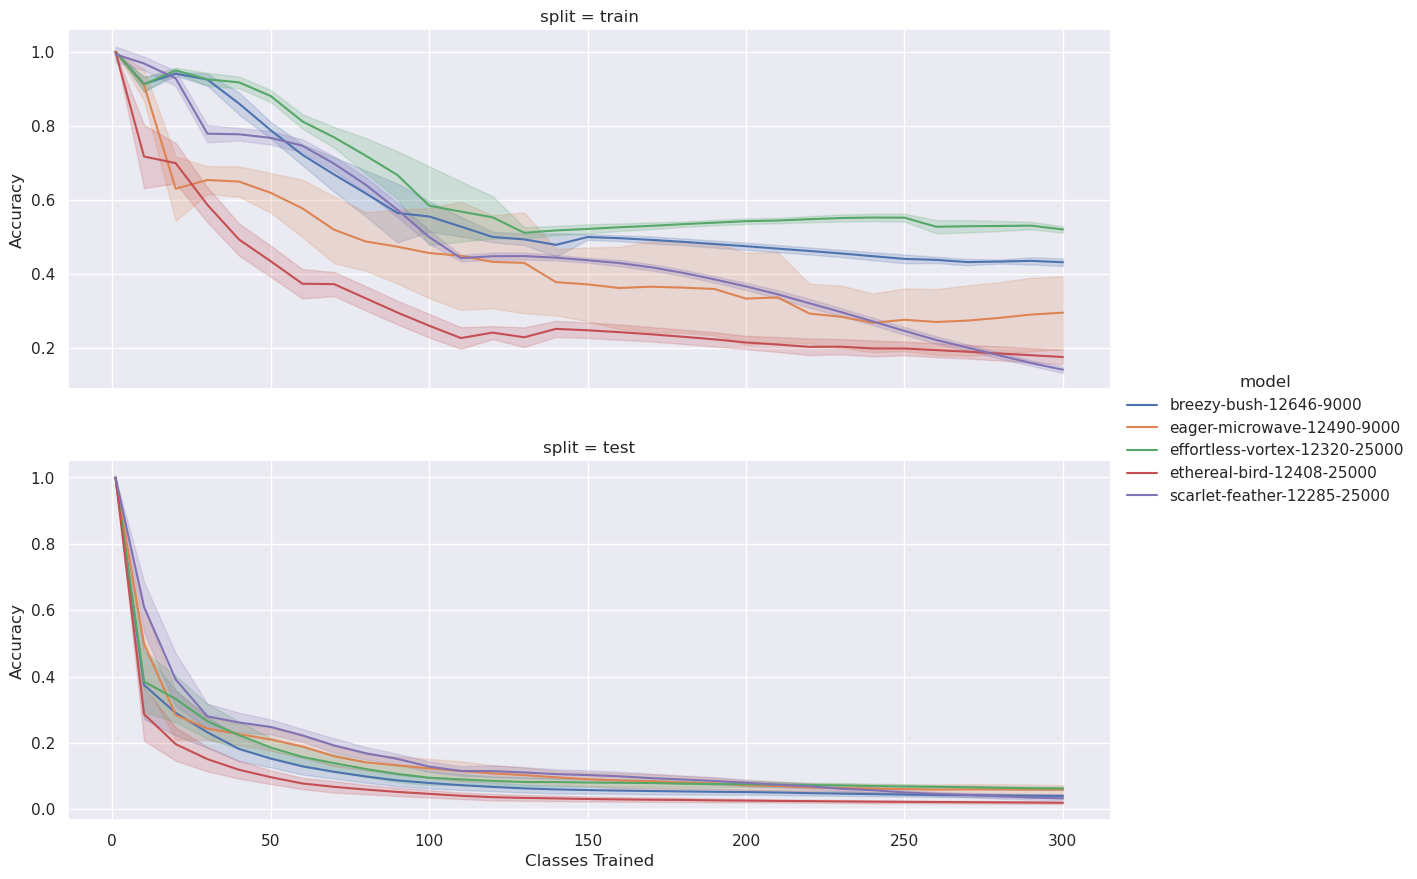

In [116]:
# Re-do the plot with just the top models.
_ = plot_traj_per_lr(top_model_df)

### Best Models Per Category

In [135]:
group_cols = ["model_name", "train_method", "lobotomize"]
best_olft_models = get_top_model_per_group(olft_best_lrs, olft_perf_per_model, group_cols)
best_olft_models

mean  \
model_name train_method        lobotomize model                                     
resnet18   iid                 False      glittering-snake-21-1260       0.006244   
sanml      iid                 False      golden-festival-79-1260        0.013511   
           meta                False      ethereal-bird-12408-25000      0.019600   
                               True       effortless-vortex-12320-25000  0.062667   
           sequential_episodic False      expert-salad-12713-9000        0.014244   
                               True       eager-microwave-12490-9000     0.058978   

                                                                              std  
model_name train_method        lobotomize model                                    
resnet18   iid                 False      glittering-snake-21-1260       0.002522  
sanml      iid                 False      golden-festival-79-1260        0.003545  
           meta                False      ethereal-bird-12408-25000      0.003548  
                               True       effortless-vortex-12320-25000  0.004783  
           sequential_episodic False      expert-salad-12713-9000        0.003433  
                               True       eager-microwave-12490-9000     0.013411

/users/n/t/ntraft/miniconda3/envs/deep-amd-3.9/lib/python3.9/site-packages/seaborn/axisgrid.py:848: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar='sd'` for the same effect.

  func(*plot_args, **plot_kwargs)
/users/n/t/ntraft/miniconda3/envs/deep-amd-3.9/lib/python3.9/site-packages/seaborn/axisgrid.py:848: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar='sd'` for the same effect.

  func(*plot_args, **plot_kwargs)


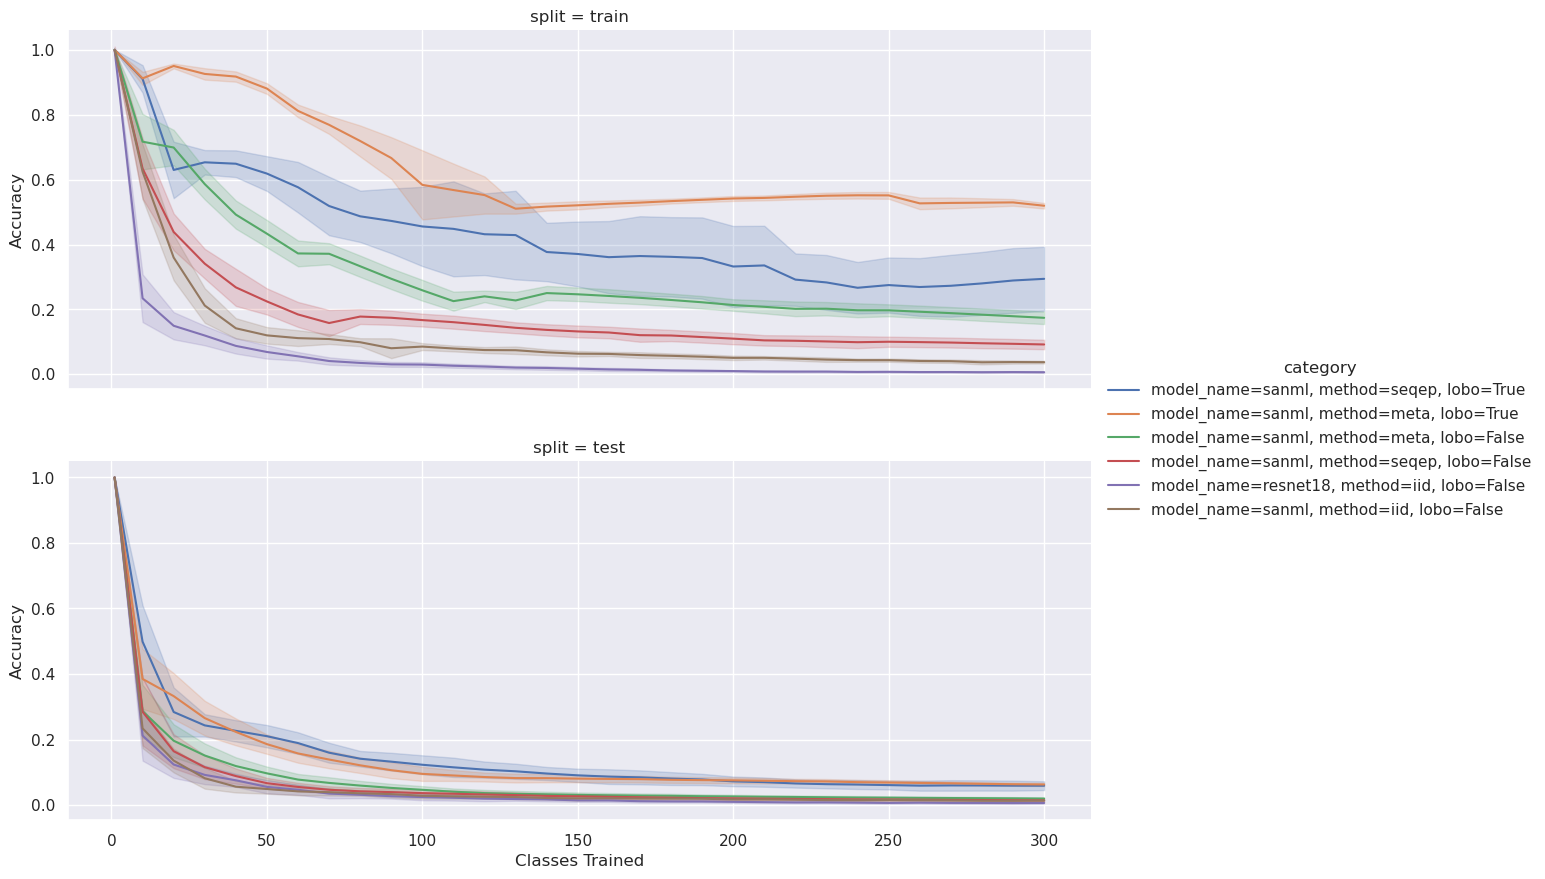

In [136]:
# Now plot them.
best_olft_df = filter_to_match_models(olft_best_lrs, best_olft_models).copy()
add_category_column(best_olft_df, group_cols)
_ = plot_traj_per_lr(best_olft_df, hue="category")

# i.i.d. Fine-Tuning Evaluation

## Unfrozen

### Best Models Per Category

In [144]:
iid_df = drop_top5_columns(all_frames["iid-unfrozen"])
iid_df = filter_by_value(iid_df, "train_dataset", "omniimage20")
iid_overall_accuracy = combine_train_test_columns(iid_df)
iid_overall_accuracy = rename_like_models(iid_overall_accuracy)

In [145]:
iid_overall_accuracy.index.get_level_values("train_examples").unique()

Int64Index([15], dtype='int64', name='train_examples')

In [146]:
# Filter the data to the desired number of training examples.
# num_train_examples = 500
# rows = iid_overall_accuracy.index.get_level_values("train_examples") == num_train_examples
# iid_one_train_size = iid_overall_accuracy.loc[rows]

# Or, don't filter.
num_train_examples = None
iid_one_train_size = iid_overall_accuracy

# Now select one LR per pretrain group.
iid_best_lrs = select_best_lr_per_group(iid_one_train_size)

In [147]:
get_model_descriptions(iid_best_lrs)

,train_dataset,model_name,train_method,lobotomize,train_lr,inner_lr,outer_lr,seed
model,,,,,,,,
absurd-monkey-12273-25000,omniimage20,sanml,meta,True,0.0000,0.001,0.001,29384
ancient-puddle-12220-25000,omniimage20,sanml,meta,True,0.0000,0.010,0.001,29384
auspicious-dumpling-27-1260,omniimage20,resnet18,iid,False,0.0003,0.000,0.000,29384
beaming-rabbit-47-1260,omniimage20,sanml,iid,False,0.0030,0.000,0.000,29384
breezy-bush-12646-9000,omniimage20,sanml,sequential_episodic,True,0.0000,0.001,0.010,29384
brilliant-pig-60-1260,omniimage20,sanml,iid,False,0.0010,0.000,0.000,29384
eager-microwave-12490-9000,omniimage20,sanml,sequential_episodic,True,0.0000,0.001,0.001,29384
effortless-vortex-12320-25000,omniimage20,sanml,meta,True,0.0000,0.001,0.010,49289
ethereal-bird-12408-25000,omniimage20,sanml,meta,False,0.0000,0.001,0.010,29384


In [148]:
# Print final accuracy per model, when fine-tuned on this number of examples.
iid_perf_per_model = get_final_perf_per_model(iid_best_lrs, num_train_examples, print_result=True)

Final accuracy on 300 classes:
     absurd-monkey-12273-25000 | 24.7% (std: 0.9%)
    ancient-puddle-12220-25000 | 22.2% (std: 2.3%)
   auspicious-dumpling-27-1260 |  1.1% (std: 0.3%)
        beaming-rabbit-47-1260 |  6.9% (std: 0.7%)
        breezy-bush-12646-9000 | 13.3% (std: 0.7%)
         brilliant-pig-60-1260 |  6.8% (std: 0.7%)
    eager-microwave-12490-9000 | 19.7% (std: 0.9%)
 effortless-vortex-12320-25000 | 18.9% (std: 0.6%)
     ethereal-bird-12408-25000 |  8.1% (std: 0.7%)
       expert-salad-12713-9000 |  8.2% (std: 0.8%)
       fluent-paper-12697-9000 | 11.8% (std: 0.7%)
     genial-silence-12451-9000 |  2.3% (std: 0.7%)
      glad-serenity-12670-9000 |  9.8% (std: 0.7%)
        glittering-pig-24-1260 |  2.1% (std: 0.5%)
      glittering-snake-21-1260 |  6.6% (std: 0.8%)
       golden-festival-79-1260 |  5.6% (std: 0.5%)
         soft-dust-12337-25000 | 12.4% (std: 0.7%)
    sparkling-lion-12354-25000 | 14.1% (std: 1.0%)


In [149]:
group_cols = ["model_name", "train_method", "lobotomize"]
best_iid_models = get_top_model_per_group(iid_best_lrs, iid_perf_per_model, group_cols)
best_iid_models

mean  \
model_name train_method        lobotomize model                                  
resnet18   iid                 False      glittering-snake-21-1260    0.066000   
sanml      iid                 False      beaming-rabbit-47-1260      0.069044   
           meta                False      sparkling-lion-12354-25000  0.141433   
                               True       absurd-monkey-12273-25000   0.247333   
           sequential_episodic False      fluent-paper-12697-9000     0.118022   
                               True       eager-microwave-12490-9000  0.197400   

                                                                           std  
model_name train_method        lobotomize model                                 
resnet18   iid                 False      glittering-snake-21-1260    0.008354  
sanml      iid                 False      beaming-rabbit-47-1260      0.006510  
           meta                False      sparkling-lion-12354-25000  0.009784  
                               True       absurd-monkey-12273-25000   0.009038  
           sequential_episodic False      fluent-paper-12697-9000     0.007433  
                               True       eager-microwave-12490-9000  0.009373

/users/n/t/ntraft/miniconda3/envs/deep-amd-3.9/lib/python3.9/site-packages/seaborn/axisgrid.py:848: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar='sd'` for the same effect.

  func(*plot_args, **plot_kwargs)
/users/n/t/ntraft/miniconda3/envs/deep-amd-3.9/lib/python3.9/site-packages/seaborn/axisgrid.py:848: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar='sd'` for the same effect.

  func(*plot_args, **plot_kwargs)


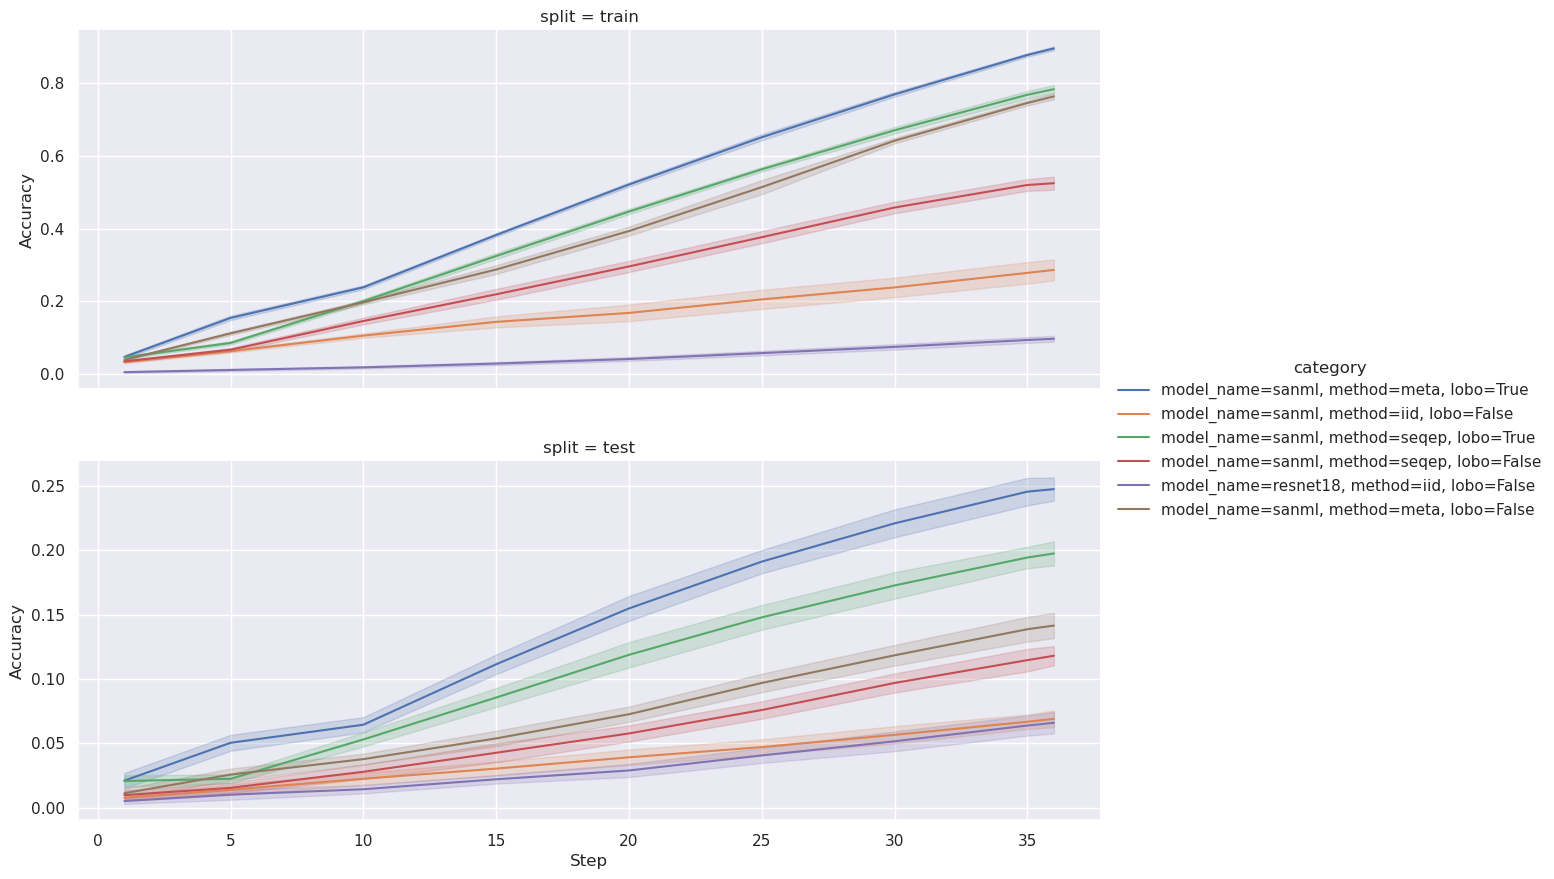

In [150]:
# Now plot them. Copy to avoid a SettingWithCopy warning.
best_iid_df = filter_to_match_models(iid_best_lrs, best_iid_models).copy()
add_category_column(best_iid_df, group_cols)
_ = plot_traj_per_lr(best_iid_df, hue="category")

# No SGD ("Zero-Shot") Results

In [151]:
zero_df = drop_top5_columns(all_frames["no-sgd"])
zero_df = filter_by_value(zero_df, "train_dataset", "omni")
z_overall_accuracy = combine_train_test_columns(zero_df)
z_overall_accuracy = rename_like_models(z_overall_accuracy)
z_overall_accuracy

accuracy
model                    train_dataset model_name train_method        lobotomize train_lr inner_lr outer_lr eval_dataset train_examples test_examples eval_method reinit_method reinit_params     classes trial seed  split          
angelic-balloon-100-570  omni          sanml      iid                 False      0.0003   0.00     0.000    omni         15             5             zero_shot   lstsq         classifier.linear 600     0     49289 train  0.996778
                                                                                                                                                                                                          1     49289 train  0.998222
                                                                                                                                                                                                          2     49289 train  0.996778
                                                                                                                                                                                                          3     49289 train  0.997111
                                                                                                                                                                                                          4     49289 train  0.996667
...                                                                                                                                                                                                                               ...
effusive-romance-75-9000 omni          sanml      sequential_episodic True       0.0000   0.01     0.001    omni         15             5             zero_shot   lstsq         classifier.linear 600     5     29384 test   0.773667
                                                                                                                                                                                                          6     29384 test   0.753333
                                                                                                                                                                                                          7     29384 test   0.759333
                                                                                                                                                                                                          8     29384 test   0.776667
                                                                                                                                                                                                          9     29384 test   0.752000

[1260 rows x 1 columns]

In [152]:
# Print final accuracy per model, when fine-tuned on this number of examples.
z_perf_per_model = get_final_perf_per_model(z_overall_accuracy, num_train_examples, print_result=True)

Final accuracy on 600 classes:
          ablaze-ring-62-25000 | 64.8% (std: 0.9%)
    affectionate-flower-96-570 | 75.1% (std: 5.4%)
       angelic-balloon-100-570 | 69.6% (std: 6.0%)
 attractive-heartthrob-103-570 | 72.8% (std: 4.5%)
      blazing-darling-60-25000 | 75.3% (std: 0.7%)
        blazing-tulip-66-25000 | 60.2% (std: 2.4%)
      cherubic-flower-58-25000 | 76.6% (std: 0.6%)
       constant-violet-85-9000 | 64.1% (std: 0.9%)
     dedicated-darling-82-9000 | 56.6% (std: 1.0%)
         deeply-crush-70-25000 | 61.9% (std: 1.8%)
     deeply-sweetheart-88-9000 | 65.0% (std: 0.9%)
         dreamy-heart-71-25000 | 48.0% (std: 2.0%)
      effusive-romance-75-9000 | 64.3% (std: 19.1%)
        enamored-crush-77-9000 | 74.3% (std: 0.7%)
enthusiastic-candy-heart-90-9000 | 52.6% (std: 1.9%)


In [153]:
_ = get_final_perf_per_model(z_overall_accuracy, num_train_examples, split="train", print_result=True)

Final accuracy on 600 classes:
          ablaze-ring-62-25000 | 99.9% (std: 0.0%)
    affectionate-flower-96-570 | 98.0% (std: 2.7%)
       angelic-balloon-100-570 | 97.5% (std: 3.4%)
 attractive-heartthrob-103-570 | 96.7% (std: 4.4%)
      blazing-darling-60-25000 | 100.0% (std: 0.0%)
        blazing-tulip-66-25000 | 99.9% (std: 0.0%)
      cherubic-flower-58-25000 | 99.9% (std: 0.0%)
       constant-violet-85-9000 | 99.9% (std: 0.0%)
     dedicated-darling-82-9000 | 100.0% (std: 0.0%)
         deeply-crush-70-25000 | 99.9% (std: 0.0%)
     deeply-sweetheart-88-9000 | 99.9% (std: 0.0%)
         dreamy-heart-71-25000 | 99.6% (std: 0.8%)
      effusive-romance-75-9000 | 86.3% (std: 22.6%)
        enamored-crush-77-9000 | 99.9% (std: 0.0%)
enthusiastic-candy-heart-90-9000 | 99.8% (std: 0.3%)


# Quick Analysis

Chaining together all the processing methods in a single cell for quick reporting on any selected subset of results.

In [37]:
# What frames are available?
#sorted(all_frames.keys())
# Which datasets are available in this frame?
all_frames["iid-unfrozen-5epochs"].index.get_level_values("train_dataset").unique()
# Do we have different amounts of training data here?
#all_frames["iid-unfrozen-lg"].index.get_level_values("train_examples").unique()

Index(['omni', 'omniimage20', 'miniimagenet'], dtype='object', name='train_dataset')

In [45]:
%%time
pre_df = drop_top5_columns(all_frames["iid-unfrozen-5epochs"])
pre_df = summarize_per_class_performance(pre_df, inplace=True)
pre_df = filter_by_value(pre_df, "train_dataset", "omniimage20")
print(f"Train examples: {list(pre_df.index.get_level_values('train_examples').unique())}")
print(f"Test examples: {list(pre_df.index.get_level_values('test_examples').unique())}")

Train examples: [15]
Test examples: [5]
CPU times: user 27.7 ms, sys: 66 µs, total: 27.8 ms
Wall time: 26.9 ms


In [50]:
num_train_examples = None
df = maybe_filter_by_value(pre_df, "train_examples", num_train_examples)
df = maybe_filter_by_value(df, "test_examples", None)
df = combine_train_test_columns(df)
df = rename_like_models(df)
best_lrs = select_best_lr_per_group(df)
_ = get_final_perf_per_model(best_lrs, num_train_examples, split="train", print_result=True)
print()
perf_per_model = get_final_perf_per_model(best_lrs, num_train_examples, split="test", print_result=True)
group_cols = ["model_name", "train_method", "lobotomize"]
best_models = get_top_model_per_group(best_lrs, perf_per_model, group_cols)
best_models

Final accuracy on 300 classes:
     absurd-monkey-12273-25000 | 100.0% (std: 0.0%)
    ancient-puddle-12220-25000 | 100.0% (std: 0.0%)
   auspicious-dumpling-27-1260 | 26.0% (std: 10.9%)
        beaming-rabbit-47-1260 | 99.5% (std: 0.6%)
        breezy-bush-12646-9000 | 100.0% (std: 0.0%)
         brilliant-pig-60-1260 | 99.8% (std: 0.1%)
        dulcet-eon-12395-25000 | 100.0% (std: 0.0%)
    eager-microwave-12490-9000 | 100.0% (std: 0.0%)
 effortless-vortex-12320-25000 | 100.0% (std: 0.0%)
     ethereal-bird-12408-25000 | 99.6% (std: 0.3%)
       expert-salad-12713-9000 | 99.9% (std: 0.0%)
       fluent-paper-12697-9000 | 100.0% (std: 0.0%)
     genial-silence-12451-9000 | 17.5% (std: 5.3%)
      glad-serenity-12670-9000 | 100.0% (std: 0.0%)
        glittering-pig-24-1260 | 42.0% (std: 2.6%)
      glittering-snake-21-1260 | 54.6% (std: 1.7%)
       golden-festival-79-1260 | 99.7% (std: 0.2%)
         soft-dust-12337-25000 | 100.0% (std: 0.0%)

Final accuracy on 300 classes:
     absu

mean  \
model_name train_method        lobotomize model                                  
resnet18   iid                 False      glittering-snake-21-1260    0.204356   
sanml      iid                 False      golden-festival-79-1260     0.163067   
           meta                False      dulcet-eon-12395-25000      0.180489   
                               True       absurd-monkey-12273-25000   0.304733   
           sequential_episodic False      fluent-paper-12697-9000     0.190689   
                               True       eager-microwave-12490-9000  0.248044   

                                                                           std  
model_name train_method        lobotomize model                                 
resnet18   iid                 False      glittering-snake-21-1260    0.013180  
sanml      iid                 False      golden-festival-79-1260     0.011792  
           meta                False      dulcet-eon-12395-25000      0.009376  
                               True       absurd-monkey-12273-25000   0.010847  
           sequential_episodic False      fluent-paper-12697-9000     0.008895  
                               True       eager-microwave-12490-9000  0.009477

/users/n/t/ntraft/miniconda3/envs/deep-amd-3.9/lib/python3.9/site-packages/seaborn/axisgrid.py:848: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar='sd'` for the same effect.

  func(*plot_args, **plot_kwargs)
/users/n/t/ntraft/miniconda3/envs/deep-amd-3.9/lib/python3.9/site-packages/seaborn/axisgrid.py:848: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar='sd'` for the same effect.

  func(*plot_args, **plot_kwargs)


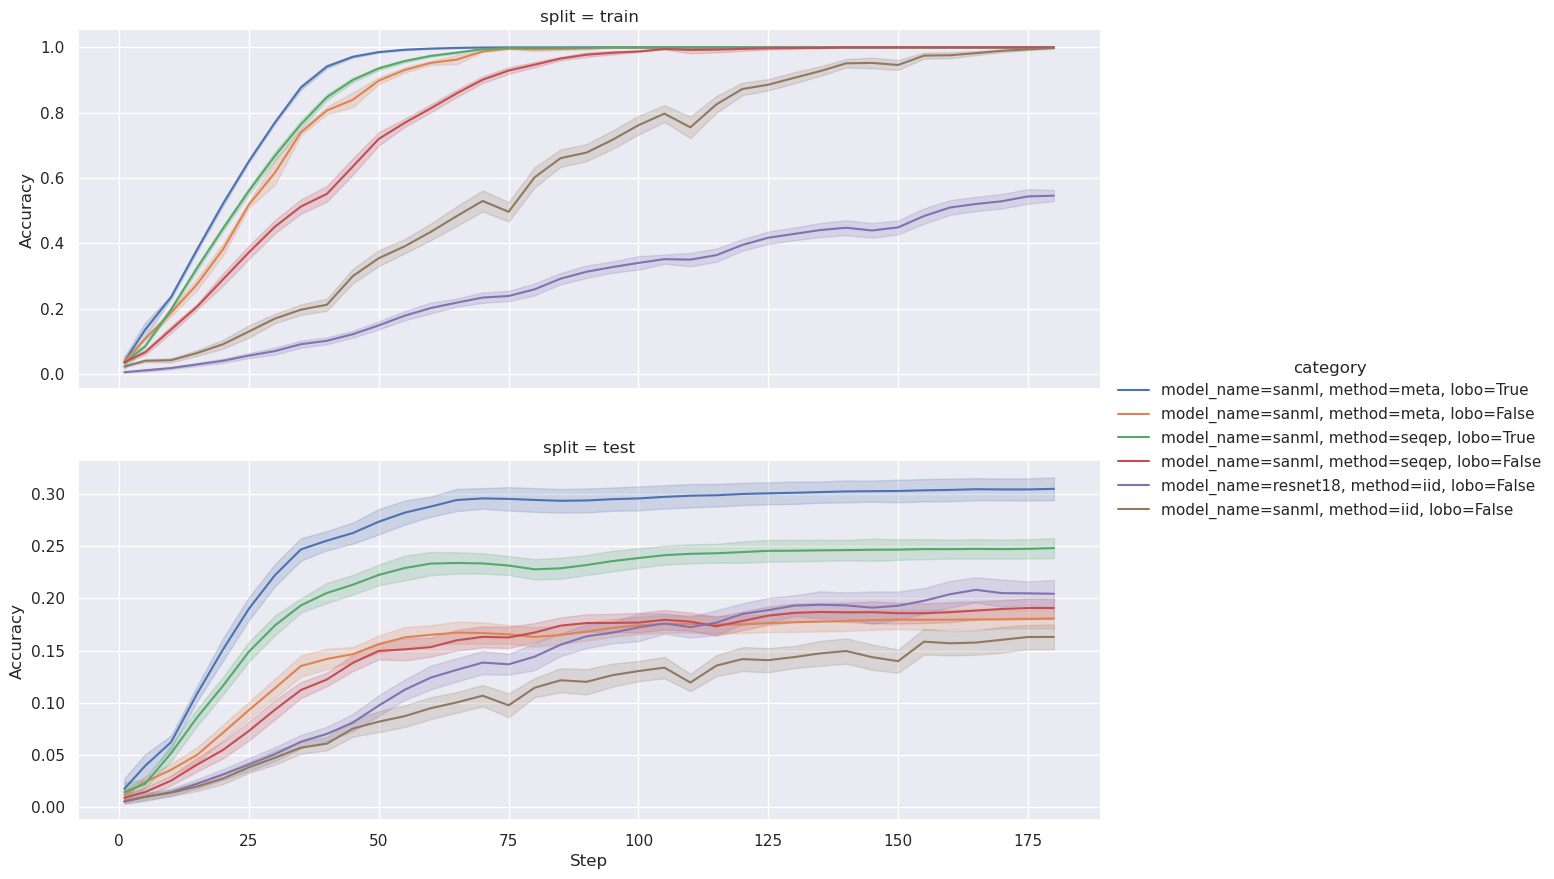

In [51]:
# Now plot them. Copy to avoid a SettingWithCopy warning.
best_overall = filter_to_match_models(best_lrs, best_models).copy()
add_category_column(best_overall, group_cols)
_ = plot_traj_per_lr(best_overall, hue="category")

In [52]:
get_model_descriptions(best_overall)

,train_dataset,model_name,train_method,lobotomize,train_lr,inner_lr,outer_lr,seed
model,,,,,,,,
absurd-monkey-12273-25000,omniimage20,sanml,meta,True,0.0000,0.001,0.001,29384
dulcet-eon-12395-25000,omniimage20,sanml,meta,False,0.0000,0.001,0.001,29384
eager-microwave-12490-9000,omniimage20,sanml,sequential_episodic,True,0.0000,0.001,0.001,29384
fluent-paper-12697-9000,omniimage20,sanml,sequential_episodic,False,0.0000,0.001,0.001,29384
glittering-snake-21-1260,omniimage20,resnet18,iid,False,0.0030,0.000,0.000,29384
golden-festival-79-1260,omniimage20,sanml,iid,False,0.0003,0.000,0.000,29384


/users/n/t/ntraft/miniconda3/envs/deep-amd-3.9/lib/python3.9/site-packages/seaborn/axisgrid.py:848: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar='sd'` for the same effect.

  func(*plot_args, **plot_kwargs)
/users/n/t/ntraft/miniconda3/envs/deep-amd-3.9/lib/python3.9/site-packages/seaborn/axisgrid.py:848: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar='sd'` for the same effect.

  func(*plot_args, **plot_kwargs)


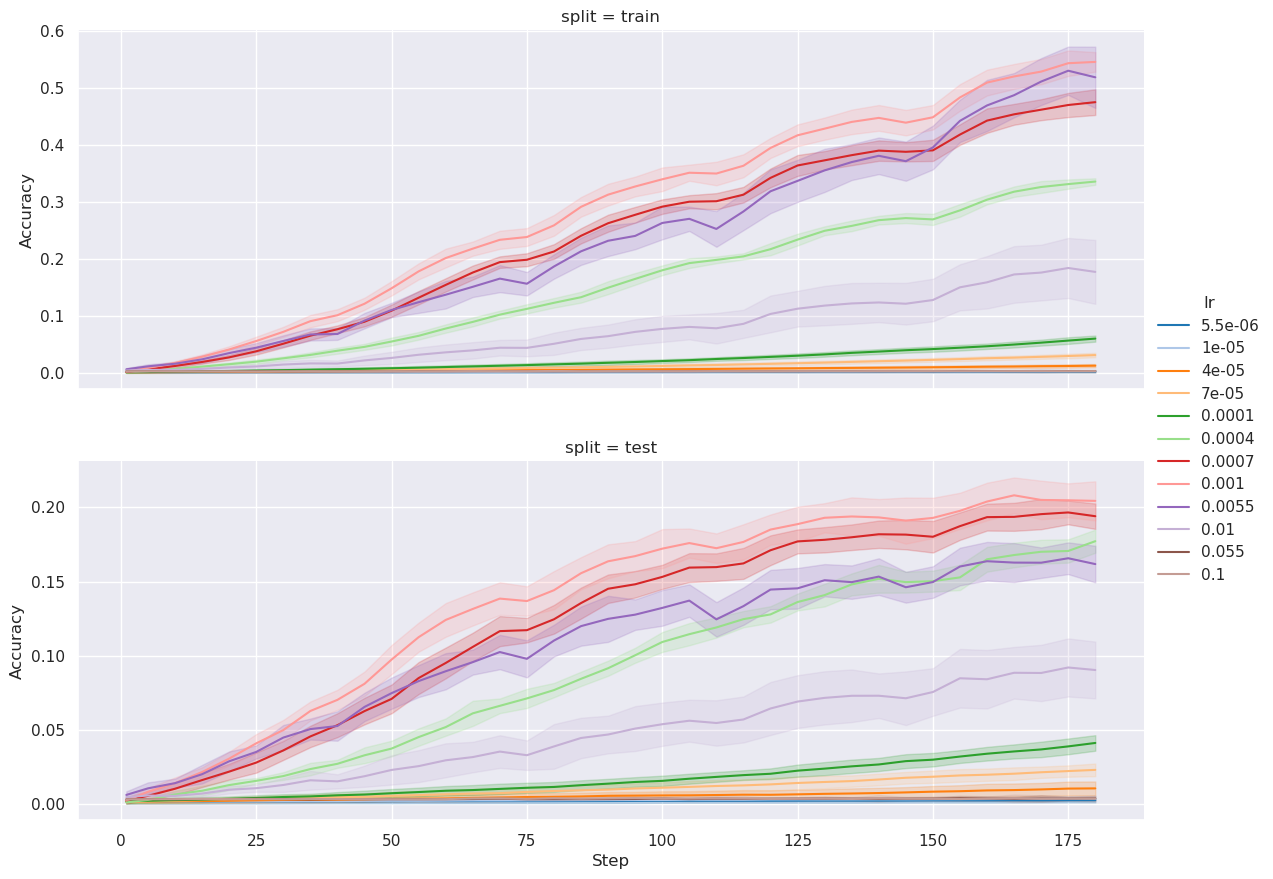

In [55]:
rows = df.index.get_level_values("model") == "glittering-snake-21-1260"
desired_rows = df.loc[rows]
fg = plot_traj_per_lr(desired_rows, palette="tab20")

/users/n/t/ntraft/miniconda3/envs/deep-amd-3.9/lib/python3.9/site-packages/seaborn/axisgrid.py:848: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar='sd'` for the same effect.

  func(*plot_args, **plot_kwargs)
/users/n/t/ntraft/miniconda3/envs/deep-amd-3.9/lib/python3.9/site-packages/seaborn/axisgrid.py:848: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar='sd'` for the same effect.

  func(*plot_args, **plot_kwargs)


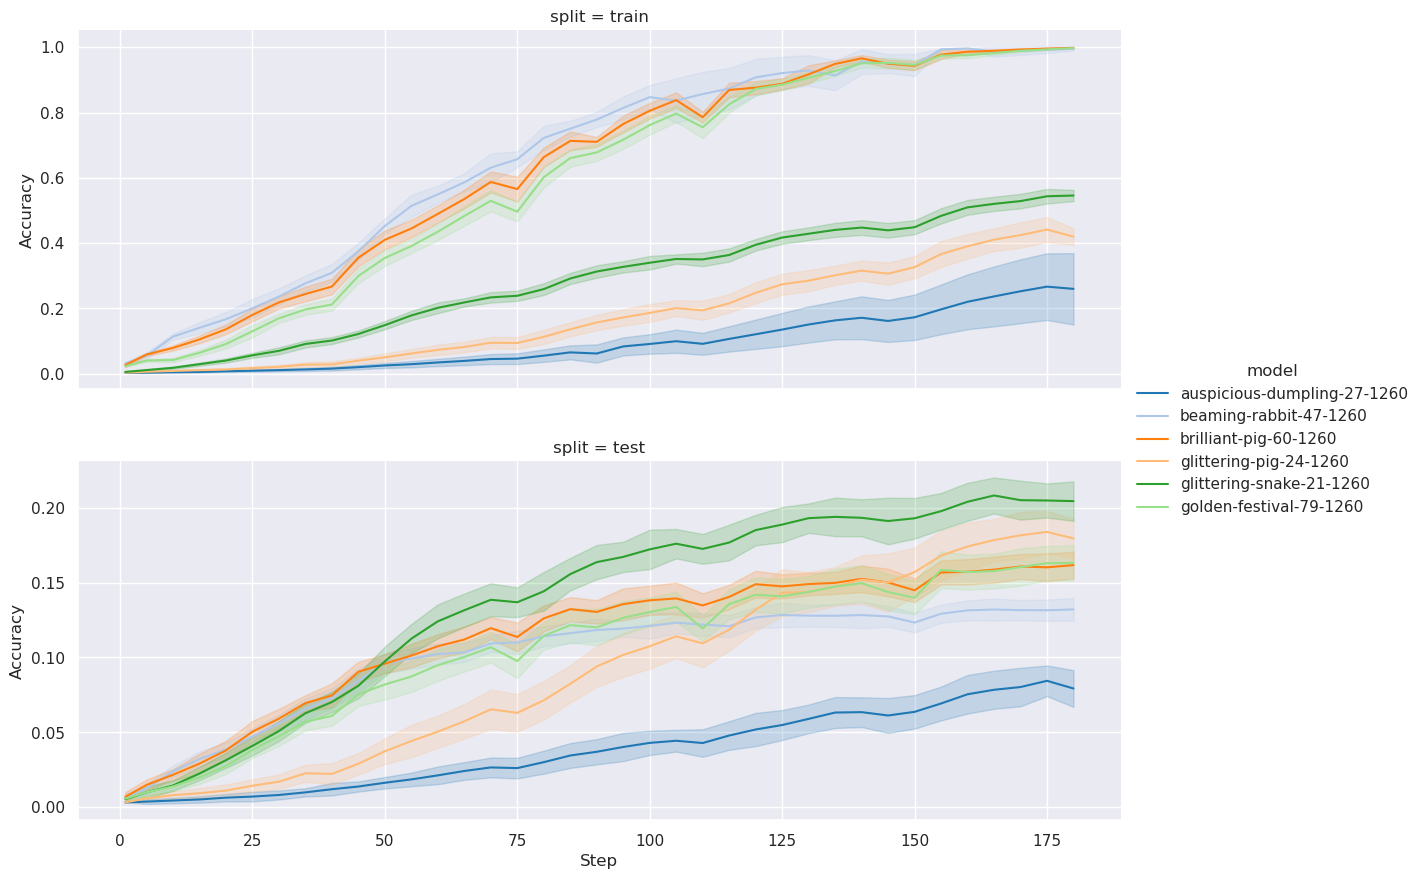

In [57]:
iid_df = maybe_filter_by_value(df, "train_method", "iid")
iid_df = select_best_lr_per_group(iid_df)
fg = plot_traj_per_lr(iid_df, palette="tab20")

In [58]:
get_model_descriptions(iid_df)

,train_dataset,model_name,train_method,lobotomize,train_lr,inner_lr,outer_lr,seed
model,,,,,,,,
auspicious-dumpling-27-1260,omniimage20,resnet18,iid,False,0.0003,0.0,0.0,29384
beaming-rabbit-47-1260,omniimage20,sanml,iid,False,0.0030,0.0,0.0,29384
brilliant-pig-60-1260,omniimage20,sanml,iid,False,0.0010,0.0,0.0,29384
glittering-pig-24-1260,omniimage20,resnet18,iid,False,0.0010,0.0,0.0,29384
glittering-snake-21-1260,omniimage20,resnet18,iid,False,0.0030,0.0,0.0,29384
golden-festival-79-1260,omniimage20,sanml,iid,False,0.0003,0.0,0.0,29384


# Sensitivity to Learning Rate (Deprecated)

This section has not yet been updated to conform to the new dataframe format.

CPU times: user 2.2 s, sys: 59.4 ms, total: 2.26 s
Wall time: 3.35 s


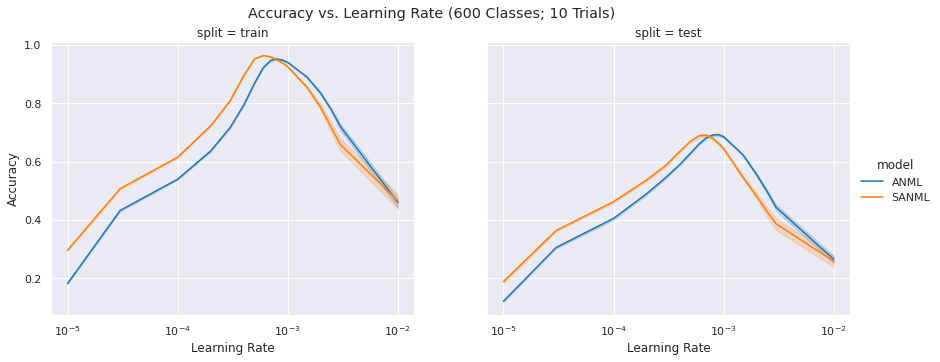

In [52]:
%%time

import warnings
from numbers import Number

# We want to plot the result of learning this number of classes across different choices of learning rate.
def plot_perf_vs_learning_rate(df, num_classes_learned, lr_range=None):

    # Filter down to just the slice that has learned this many classes.
    if isinstance(num_classes_learned, Number):
        # Convert to list of numbers first.
        num_classes_learned = [num_classes_learned]
    classes_trained = df.index.get_level_values("classes_trained")
    df = df.loc[classes_trained.map(lambda x: x in num_classes_learned), :]
    
    # Filter to only the desired learning rates.
    if lr_range:
        assert len(lr_range) == 2
        lrs = df.index.get_level_values("lr")
        rows = (lrs >= lr_range[0]) & (lrs <= lr_range[1])
        df = df.loc[rows, :]        
    
    # We want to make sure we are not accidentally aggregating across runs with different configs.
    ensure_unique(df, ["eval_dataset", "num_test_examples"])
    # Only add more levels of nesting if needed.
    hue = None
    if df.index.get_level_values("model").nunique() > 1:
        hue = "model"
    style = None
    nte = df.index.get_level_values("num_train_examples")
    ct = df.index.get_level_values("classes_trained")
    if nte.nunique() > 1 and ct.nunique() > 1:
        # We can't have both of these at once.
        raise RuntimeError("Cannot show multiple values of both 'num_train_examples' and 'classes_trained'.")
    elif ct.nunique() > 1:
        style = "classes_trained"
    elif nte.nunique() > 1:
        style = "num_train_examples"

    # Temporarily suppress this annoying and unnecessary warning coming from Seaborn.
    with warnings.catch_warnings():
        warnings.filterwarnings("ignore", message=".*not compatible with tight_layout.*")
        fg = sns.relplot(
            data=df,
            x="lr",
            y="accuracy",
            col="split",
            hue=hue,
            style=style,
            palette="tab10",
            kind="line",
            #ci="sd",  # Remove this to plot 95% CI instead. It will take a long time.
            aspect=1.3,
            facet_kws=dict(gridspec_kws=dict(top=0.88))
        )
    # Adjust labels.
    ntrials = df.index.get_level_values("trial").nunique()
    fg.set(xscale="log")
    cls_text = ""
    if len(num_classes_learned) == 1:
        cls_text = f"{num_classes_learned[0]} Classes; "
    fg.figure.suptitle(f"Accuracy vs. Learning Rate ({cls_text}{ntrials} Trials)")
    fg.set_axis_labels("Learning Rate", "Accuracy")


# Determine which point(s) on the learning trajectories to plot.
num_classes = [600]
# Now do the plotting.
plot_perf_vs_learning_rate(olft_overall_accuracy, num_classes)#, lr_range=(float("-inf"), 0.03))

# Launching Additional Evals

This section is used for scanning existing models and launching jobs to evaluate them if they are missing a particular flavor of evaluation.

Define some functions and imports up front which will be used by multiple different cells.

In [12]:
import launch_eval_map as evaljob
from utils import ensure_config_param, update_with_keys
from utils.logging import check_eval_config


def has_eval_data(folder):
    return len(list(folder.glob("*.pkl"))) > 0


def get_flavor_config(train_cfg, target_flavor):
    cfg_list = train_cfg["eval"]
    if not isinstance(cfg_list, list):
        cfg_list = [cfg_list]
    for eval_cfg in cfg_list:
        # If the config only has one key, then this names the "flavor" of the evaluation, and the corresponding
        # value is actually the config.
        if len(eval_cfg) == 1:
            flavor, eval_cfg = next(iter(eval_cfg.items()))
            if flavor == target_flavor:
                return eval_cfg
    raise RuntimeError(f'Could not find flavor "{target_flavor}" in the training config.')


def get_configs_for_eval(eval_folder):
    # NOTE: Assumes one config per folder.
    eval_cfg = load_yaml(next(iter(eval_folder.glob("eval-config-*.yml"))))
    train_cfg = train_configs[eval_folder.parent.stem]
    return train_cfg, eval_cfg


def get_prepared_configs_for_eval(flavor, eval_folder):
    train_cfg, disk_eval_cfg = get_configs_for_eval(eval_folder)

    # Instead of loading the eval config from the folder, we are taking it from the train config. This is because
    # the version in the eval folder has already been split up into multiple sub-jobs.
    eval_cfg = get_flavor_config(train_cfg, flavor)
    eval_cfg = eval_cfg.copy()  # copy before editing
    eval_cfg["model"] = disk_eval_cfg["model"]
    update_with_keys(train_cfg, eval_cfg, ["project", "entity", "group", "model_name", "train_method"])
    eval_cfg.setdefault("group", disk_eval_cfg.get("group"))

    check_eval_config(eval_cfg)
    return train_cfg, eval_cfg


The first cell below is just for printing info about missing data.

In [199]:
total = len(all_eval_folders)
for i, (name, eval_folders) in enumerate(all_eval_folders.items()):
    #print(f"({i+1}/{total}) Loading {len(eval_folders)} evaluations for {name}...")
    for f in eval_folders:
        if not has_eval_data(f):
            print(f"Data is missing from {name}/{flavor_from_folder(f)}")

Data is missing from absurd-monkey-12273/unfrozen
Data is missing from beaming-lantern-227/no-sgd-lg
Data is missing from fortuitous-dumpling-9182/no-sgd
Data is missing from glistening-wish-233/no-sgd
Data is missing from glistening-wish-233/no-sgd-lg
Data is missing from golden-orchid-9180/iid-unfrozen-lg
Data is missing from luminous-cake-207/no-sgd
Data is missing from luminous-cake-207/no-sgd-lg
Data is missing from luminous-dumpling-9181/iid-unfrozen-lg
Data is missing from virtuous-peony-9178/iid-unfrozen-lg
Data is missing from vivid-envelope-196/iid-unfrozen-lg
Data is missing from wise-deluge-3747/no-sgd


This next cell relaunches an existing flavor if it's missing data.

In [209]:

def relaunch_existing_eval(flavor, eval_folder, cluster=None):
    train_cfg, eval_cfg = get_prepared_configs_for_eval(flavor, eval_folder)
    if cluster is None:
        cluster = train_cfg["cluster"]

    retcode = evaljob.launch(eval_cfg, flavor=flavor, cluster=cluster, launcher_args=["--mem=12G"], force=True)
    if retcode != 0:
        print(f"WARNING: Eval job may not have launched. Launcher exited with code {retcode}. See above for"
              " possible errors.")


desired_flavor = "unfrozen"
cluster = "bdgpu"

# Iterate over all models.
total = len(all_eval_folders)
for i, (name, eval_folders) in enumerate(all_eval_folders.items()):
    #print(f"({i+1}/{total}) Loading {len(eval_folders)} evaluations for {name}...")
    available_flavors = [flavor_from_folder(f) for f in eval_folders]
    try:
        flavdex = available_flavors.index(desired_flavor)
        flav_folder = eval_folders[flavdex]
        if not has_eval_data(flav_folder):
            print(f"Flavor is missing from {name}.")
            relaunch_existing_eval(desired_flavor, flav_folder, cluster)

    except ValueError:
        continue

Flavor is missing from absurd-monkey-12273.
Running command: launcher bdgpu -f -d /gpfs2/scratch/ntraft/Development/higherANML/experiments/monster/absurd-monkey-12273/eval-classifier-25000-unfrozen --argfile /gpfs2/scratch/ntraft/Development/higherANML/experiments/monster/absurd-monkey-12273/eval-classifier-25000-unfrozen/args-3d902e380b2045a093129d93e6e28c5e.txt --mem=12G /gpfs2/scratch/ntraft/Development/higherANML/eval_map.py --config /gpfs2/scratch/ntraft/Development/higherANML/experiments/monster/absurd-monkey-12273/eval-classifier-25000-unfrozen/eval-config-3d902e380b2045a093129d93e6e28c5e.yml --data-path /gpfs2/scratch/ntraft/Development/higherANML/experiments/data
Submitted batch job 6996740


This next cell launches a new flavor, if it doesn't already exist.

In [22]:

def launch_new_eval(orig_flavor, eval_folder, new_flavor, modifications, cluster=None):
    train_cfg, eval_cfg = get_prepared_configs_for_eval(orig_flavor, eval_folder)
    eval_cfg.update(modifications)
    if cluster is None:
        cluster = train_cfg["cluster"]

    retcode = evaljob.launch(eval_cfg, flavor=new_flavor, cluster=cluster, launcher_args=["--mem=12G"], force=True)
    if retcode != 0:
        print(f"WARNING: Eval job may not have launched. Launcher exited with code {retcode}. See above for"
              " possible errors.")


orig_flavor = "iid-unfrozen"
new_flavor = "iid-unfrozen-5epochs"
dataset = "omniimage"
imgs_per_class = 20
cluster = "bdgpu"
modifications = {
    "epochs": 5
}

# Iterate over all models.
total = len(all_eval_folders)
count = 0
for i, (name, eval_folders) in enumerate(all_eval_folders.items()):
    #print(f"({i+1}/{total}) Loading {len(eval_folders)} evaluations for {name}...")
    for f in eval_folders:
        if flavor_from_folder(f) == orig_flavor:
            train_cfg = train_configs[f.parent.stem]
            if train_cfg["dataset"] == dataset and train_cfg.get("imgs_per_class") == imgs_per_class:
                print(f"\nLaunching eval for {f.parent.stem}...")
                launch_new_eval(orig_flavor, f, new_flavor, modifications, cluster)
                count += 1

print(f"\nLaunched a total of {count} jobs.")


Launching eval for absurd-monkey-12273...
Running command: launcher bdgpu -f -d /gpfs2/scratch/ntraft/Development/higherANML/experiments/monster/absurd-monkey-12273/eval-classifier-25000-iid-unfrozen-5epochs --argfile /gpfs2/scratch/ntraft/Development/higherANML/experiments/monster/absurd-monkey-12273/eval-classifier-25000-iid-unfrozen-5epochs/args-78ca242d4ede46d5ab312b99a535bcb5.txt --mem=12G /gpfs2/scratch/ntraft/Development/higherANML/eval_map.py --config /gpfs2/scratch/ntraft/Development/higherANML/experiments/monster/absurd-monkey-12273/eval-classifier-25000-iid-unfrozen-5epochs/eval-config-78ca242d4ede46d5ab312b99a535bcb5.yml --data-path /gpfs2/scratch/ntraft/Development/higherANML/experiments/data
Submitted batch job 7018540

Launching eval for ancient-puddle-12220...
Running command: launcher bdgpu -f -d /gpfs2/scratch/ntraft/Development/higherANML/experiments/monster/ancient-puddle-12220/eval-classifier-25000-iid-unfrozen-5epochs --argfile /gpfs2/scratch/ntraft/Development/h

Submitted batch job 7018552

Launching eval for ethereal-bird-12408...
Running command: launcher bdgpu -f -d /gpfs2/scratch/ntraft/Development/higherANML/experiments/monster/ethereal-bird-12408/eval-classifier-25000-iid-unfrozen-5epochs --argfile /gpfs2/scratch/ntraft/Development/higherANML/experiments/monster/ethereal-bird-12408/eval-classifier-25000-iid-unfrozen-5epochs/args-245786c649f2409caf0e7b44e07294c1.txt --mem=12G /gpfs2/scratch/ntraft/Development/higherANML/eval_map.py --config /gpfs2/scratch/ntraft/Development/higherANML/experiments/monster/ethereal-bird-12408/eval-classifier-25000-iid-unfrozen-5epochs/eval-config-245786c649f2409caf0e7b44e07294c1.yml --data-path /gpfs2/scratch/ntraft/Development/higherANML/experiments/data
Submitted batch job 7018553

Launching eval for expert-salad-12713...
Running command: launcher bdgpu -f -d /gpfs2/scratch/ntraft/Development/higherANML/experiments/monster/expert-salad-12713/eval-classifier-9000-iid-unfrozen-5epochs --argfile /gpfs2/scrat

Submitted batch job 7018564

Launching eval for legendary-bao-38...
Running command: launcher bdgpu -f -d /gpfs2/scratch/ntraft/Development/higherANML/experiments/monster/legendary-bao-38/eval-classifier-1260-iid-unfrozen-5epochs --argfile /gpfs2/scratch/ntraft/Development/higherANML/experiments/monster/legendary-bao-38/eval-classifier-1260-iid-unfrozen-5epochs/args-7756db4a274c4336924fa8e549d02e53.txt --mem=12G /gpfs2/scratch/ntraft/Development/higherANML/eval_map.py --config /gpfs2/scratch/ntraft/Development/higherANML/experiments/monster/legendary-bao-38/eval-classifier-1260-iid-unfrozen-5epochs/eval-config-7756db4a274c4336924fa8e549d02e53.yml --data-path /gpfs2/scratch/ntraft/Development/higherANML/experiments/data
Submitted batch job 7018565

Launching eval for legendary-laughter-84...
Running command: launcher bdgpu -f -d /gpfs2/scratch/ntraft/Development/higherANML/experiments/monster/legendary-laughter-84/eval-classifier-1260-iid-unfrozen-5epochs --argfile /gpfs2/scratch/ntraft

Running command: launcher bdgpu -f -d /gpfs2/scratch/ntraft/Development/higherANML/experiments/monster/soft-dust-12337/eval-classifier-25000-iid-unfrozen-5epochs --argfile /gpfs2/scratch/ntraft/Development/higherANML/experiments/monster/soft-dust-12337/eval-classifier-25000-iid-unfrozen-5epochs/args-f401800c6b464296b071f7511725c4db.txt --mem=12G /gpfs2/scratch/ntraft/Development/higherANML/eval_map.py --config /gpfs2/scratch/ntraft/Development/higherANML/experiments/monster/soft-dust-12337/eval-classifier-25000-iid-unfrozen-5epochs/eval-config-f401800c6b464296b071f7511725c4db.yml --data-path /gpfs2/scratch/ntraft/Development/higherANML/experiments/data
Submitted batch job 7018577

Launching eval for solar-lion-12623...
Running command: launcher bdgpu -f -d /gpfs2/scratch/ntraft/Development/higherANML/experiments/monster/solar-lion-12623/eval-classifier-9000-iid-unfrozen-5epochs --argfile /gpfs2/scratch/ntraft/Development/higherANML/experiments/monster/solar-lion-12623/eval-classifier-9

Running command: launcher bdgpu -f -d /gpfs2/scratch/ntraft/Development/higherANML/experiments/monster/usual-serenity-12309/eval-classifier-25000-iid-unfrozen-5epochs --argfile /gpfs2/scratch/ntraft/Development/higherANML/experiments/monster/usual-serenity-12309/eval-classifier-25000-iid-unfrozen-5epochs/args-787291e14fc5404a94c76b70a81fc55c.txt --mem=12G /gpfs2/scratch/ntraft/Development/higherANML/eval_map.py --config /gpfs2/scratch/ntraft/Development/higherANML/experiments/monster/usual-serenity-12309/eval-classifier-25000-iid-unfrozen-5epochs/eval-config-787291e14fc5404a94c76b70a81fc55c.yml --data-path /gpfs2/scratch/ntraft/Development/higherANML/experiments/data
Submitted batch job 7018590

Launching eval for virtuous-snake-23...
Running command: launcher bdgpu -f -d /gpfs2/scratch/ntraft/Development/higherANML/experiments/monster/virtuous-snake-23/eval-classifier-1260-iid-unfrozen-5epochs --argfile /gpfs2/scratch/ntraft/Development/higherANML/experiments/monster/virtuous-snake-23

# Scratch Space

In [183]:
import itertools
from copy import copy


def make_hashable(e):
    if isinstance(e, dict):
        return tuple(sorted(((k, make_hashable(v)) for k, v in e.items())))
    elif isinstance(e, (list, tuple)):
        return tuple(sorted((make_hashable(i) for i in e)))
    else:
        return e


def unique_model_desc(train_cfg):
    model_desc = copy(train_cfg)
    model_desc.pop("data_path", None)
    model_desc.pop("eval", None)
    model_desc.pop("eval_steps", None)
    model_desc.pop("cluster", None)
    model_desc.pop("group", None)
    model_desc.pop("id", None)
    return make_hashable(model_desc)


missing_evals = []
present_evals = set()
for name in train_configs:
    train_cfg = train_configs[name]
    pdir = train_config_files[name].parent
    # Check to see if a trained model is present. Grab the last one.
    trained_models = list((pdir / "trained_anmls").glob("*.net"))
    trained_models = sorted(trained_models, key=lambda f: int(f.stem.split("-")[-1]))
    final_model = trained_models[-1] if trained_models else None
    # Check to see if any evaluation is present.
    evals = list(pdir.glob("eval-*"))
    evals_with_data = list(itertools.chain(*(e.glob("*.pkl") for e in evals)))
    # Create a description of the model.
    train_method = train_cfg['train_method']
    if train_method == "sequential_episodic":
        train_method = "seqep"  # Just for a shorter output.
    model_desc = (f"{name:30} {train_method:6} {train_cfg['dataset']:13} {train_cfg.get('imgs_per_class', ''):4}"
                  f" {train_cfg['model_name']:13}")
    if final_model and not evals_with_data:
        model_desc += f" {final_model.name}"
        model_num = int(final_model.stem.split("-")[-1])
        if train_method == "meta":
            is_final = (model_num == 25000)
        elif train_method == "sequential_episodic":
            is_final = (model_num == 9000)
        elif train_method == "iid":
            is_final = (model_num == 570)
        #print(model_desc)
        #print(final_model)
        missing_evals.append((unique_model_desc(train_cfg), model_desc))
    elif evals_with_data:
        present_evals.add(unique_model_desc(train_cfg))

for m, desc in missing_evals:
    if m not in present_evals:
        print("Missing: " + desc)

In [59]:
import itertools

count = 0
for name in train_configs:
    train_cfg = train_configs[name]
    pdir = train_config_files[name].parent
    # Check to see if a trained model is present. Grab the last one.
    trained_models = list((pdir / "trained_anmls").glob("*.net"))
    trained_models = sorted(trained_models, key=lambda f: int(f.stem.split("-")[-1]))
    final_model = trained_models[-1] if trained_models else None
    # Check to see if any evaluation is present.
    evals = list(pdir.glob("eval-*"))
    evals_with_data = list(itertools.chain(*(e.glob("*.pkl") for e in evals)))
    # Create a description of the model.
    train_method = train_cfg['train_method']
    if train_method == "sequential_episodic":
        train_method = "seqep"  # Just for a shorter output.
    model_desc = (f"{name:30} {train_method:6} {train_cfg['dataset']:13} {train_cfg.get('imgs_per_class', ''):4}"
                  f" {train_cfg['model_name']:13}")
    if evals_with_data and train_cfg["dataset"] == "omniimage":
        model_desc += f" {final_model.name}"
        print(model_desc)
        count += 1

print(f"\nTotal of {count} models.")

absurd-monkey-12273            meta   omniimage       20 sanml         classifier-3-84-84-25000.net
alight-rabbit-176              iid    omniimage      100 sanml         classifier-3-84-84-6990.net
ancient-puddle-12220           meta   omniimage       20 sanml         classifier-3-84-84-25000.net
auspicious-dumpling-27         iid    omniimage       20 resnet18      classifier-3-84-84-1260.net
beaming-rabbit-47              iid    omniimage       20 sanml         classifier-3-84-84-1260.net
breezy-bush-12646              seqep  omniimage       20 sanml         classifier-3-84-84-9000.net
bright-monkey-26               iid    omniimage       20 resnet18      classifier-3-84-84-1260.net
brilliant-pig-60               iid    omniimage       20 sanml         classifier-3-84-84-1260.net
brilliant-snake-166            iid    omniimage      100 sanml         classifier-3-84-84-6990.net
chromatic-festival-44          iid    omniimage       20 sanml         classifier-3-84-84-1260.net
crimson-

In [229]:
54*7*7.5*5 / 24 / 60

9.84375